# Projet Python : Santé

**Introduction** :  


**Problématique**

In [2]:
import time
import requests
import numpy as np
import pandas as pd
from selenium import webdriver
import geckodriver_autoinstaller
from selenium.webdriver.common.action_chains import ActionChains
from selenium.common.exceptions import NoSuchElementException
import plotly.graph_objects as go
import plotly.express as px

from datetime import datetime 
from functools import reduce
import matplotlib.pyplot as plt

geckodriver_autoinstaller.install() 

'/anaconda3/lib/python3.7/site-packages/geckodriver_autoinstaller/v0.28.0/geckodriver'

# Récupération des données

## Fonctions et listes utiles au scrapping

In [3]:
noms_departements_propre = ['Ain', 'Aisne', 'Allier', 'Alpes-de-Haute-Provence', 'Hautes-Alpes',
       'Alpes-Maritimes', 'Ardèche', 'Ardennes', 'Ariège', 'Aube', 'Aude',
       'Aveyron', 'Bouches-du-Rhône', 'Calvados', 'Cantal', 'Charente',
       'Charente-Maritime', 'Cher', 'Corrèze', "Côte-d'Or", "Côtes-d'Armor",
        'Creuse', 'Dordogne', 'Doubs', 'Drôme', 'Eure', 'Eure-et-Loir',
       'Finistère', 'Corse-du-Sud', 'Haute-Corse', 'Gard', 'Haute-Garonne',
       'Gers', 'Gironde', 'Hérault', 'Ille-et-Vilaine', 'Indre',
       'Indre-et-Loire', 'Isère', 'Jura', 'Landes', 'Loir-et-Cher', 'Loire',
       'Haute-Loire', 'Loire-Atlantique', 'Loiret', 'Lot', 'Lot-et-Garonne',
       'Lozère', 'Maine-et-Loire', 'Manche', 'Marne', 'Haute-Marne', 'Mayenne',
       'Meurthe-et-Moselle', 'Meuse', 'Morbihan', 'Moselle', 'Nièvre', 'Nord',
       'Oise', 'Orne', 'Pas-de-Calais', 'Puy-de-Dôme', 'Pyrénées-Atlantiques',
       'Hautes-Pyrénées', 'Pyrénées-Orientales', 'Bas-Rhin', 'Haut-Rhin',
       'Rhône', 'Haute-Saône', 'Saône-et-Loire', 'Sarthe', 'Savoie',
       'Haute-Savoie', 'Paris', 'Seine-Maritime', 'Seine-et-Marne', 'Yvelines',
       'Deux-Sèvres', 'Somme', 'Tarn', 'Tarn-et-Garonne', 'Var', 'Vaucluse',
       'Vendée', 'Vienne', 'Haute-Vienne', 'Vosges', 'Yonne',
       'Territoire de Belfort', 'Essonne', 'Hauts-de-Seine',
       'Seine-Saint-Denis', 'Val-de-Marne', "Val-d'Oise"]

In [4]:
noms_departements = ['Ain', 'Aisne', 'Allier (03)', 'Alpes-de-Haute-Provence', 'Hautes-Alpes',
       'Alpes-Maritimes', 'Ardèche', 'Ardennes', 'Ariège', 'Aube (10)', 'Aude',
       'Aveyron', 'Bouches-du-Rhône', 'Calvados', 'Cantal', 'Charente',
       'Charente-Maritime', 'Cher (18)', 'Corrèze (19)', "Côte-d'Or", "Côtes-d'Armor (22)",
        'Creuse (23)', 'Dordogne (24)', 'Doubs (25)', 'Drôme (26)', 'Eure (27)', 'Eure-et-Loir (28)',
       'Finistère (29)', 'Corse-du-Sud (2A)', 'Haute-Corse (2B)', 'Gard (30)', 'Haute-Garonne (31)',
       'Gers (32)', 'Gironde (33)', 'Hérault (34)', 'Ille-et-Vilaine (35)', 'Indre (36)',
       'Indre-et-Loire (37)', 'Isère (38)', 'Jura (39)', 'Landes (40)', 'Loir-et-Cher (41)', 'Loire (42)',
       'Haute-Loire (43)', 'Loire-Atlantique (44)', 'Loiret (45)', 'Lot (46)', 'Lot-et-Garonne (47)',
       'Lozère (48)', 'Maine-et-Loire (49)', 'Manche (50)', 'Marne (51)', 'Haute-Marne (52)', 'Mayenne (53)',
       'Meurthe-et-Moselle (54)', 'Meuse (55)', 'Morbihan (56)', 'Moselle (57)', 'Nièvre (58)', 'Nord (59)',
       'Oise (60)', 'Orne (61)', 'Pas-de-Calais (62)', 'Puy-de-Dôme (63)', 'Pyrénées-Atlantiques (64)',
       'Hautes-Pyrénées (65)', 'Pyrénées-Orientales (66)', 'Bas-Rhin (67)', 'Haut-Rhin (68)',
       'Rhône (69)', 'Haute-Saône (70)', 'Saône-et-Loire (71)', 'Sarthe (72)', 'Savoie (73)',
       'Haute-Savoie (74)', 'Paris (75)', 'Seine-Maritime (76)', 'Seine-et-Marne (77)', 'Yvelines (78)',
       'Deux-Sèvres (79)', 'Somme (80)', 'Tarn (81)', 'Tarn-et-Garonne (82)', 'Var (83)', 'Vaucluse (84)',
       'Vendée (85)', 'Vienne (86)', 'Haute-Vienne (87)', 'Vosges (88)', 'Yonne (89)',
       'Territoire de Belfort (90)', 'Essonne (91)', 'Hauts-de-Seine (92)',
       'Seine-Saint-Denis (93)', 'Val-de-Marne (94)', "Val-d'Oise (95)"]

In [5]:
def get_column(param, driver, noms, lien, lettre, maladie, retour, covid):
    L = []
    driver.get(lien)
    time.sleep(15)
    driver.find_element_by_xpath(lettre).click()
    time.sleep(2)
    driver.find_element_by_xpath(maladie).click()
    time.sleep(2)
    if covid:
        driver.find_element_by_xpath(param[0]).click()
        time.sleep(2)
    driver.execute_script("arguments[0].scrollIntoView();", driver.find_element_by_xpath(param[1]))
    time.sleep(2)
    driver.find_element_by_xpath(param[1]).click()
    time.sleep(2)
    driver.execute_script("arguments[0].scrollIntoView();", driver.find_element_by_link_text(param[2]))
    time.sleep(2)
    ActionChains(driver).move_to_element(driver.find_element_by_link_text(param[2])).click().perform()
    time.sleep(3)
    ActionChains(driver).move_to_element(driver.find_element_by_partial_link_text("SYNTH")).click().perform()
    time.sleep(1)
    for p in range(len(noms)):
        driver.find_element_by_link_text('Rechercher un territoire').click()
        time.sleep(1)
        driver.find_element_by_xpath("//input[@class='input-in-row flex-item-fluid']").send_keys(noms[p])
        time.sleep(2)
        driver.find_element_by_xpath("//button[@data-link='{on search}']").click()
        time.sleep(2.5)
        driver.find_element_by_partial_link_text(noms[p]).click()
        time.sleep(2.5)
        ActionChains(driver).move_to_element(driver.find_element_by_xpath("//div[@class='fic-valref-buttons']")).click().perform()
        time.sleep(1)
        ActionChains(driver).move_to_element(driver.find_element_by_xpath("//a[@class='grille no-print']")).click().perform()
        time.sleep(2)
        try:
            driver.find_element_by_link_text('Données').click()
            time.sleep(1)
        except NoSuchElementException:
            ActionChains(driver).move_to_element(driver.find_element_by_xpath("//a[@class='grille no-print']")).click().perform()
            time.sleep(2)
            driver.find_element_by_link_text('Données').click()
            time.sleep(1)
        Table = driver.find_element_by_xpath("//tbody")
        Row = Table.find_element_by_xpath("//tr")
        Cells = Row.find_elements_by_xpath("//td[2]")
        Res = [cell.text for cell in Cells]
        L.append([np.nan if (a == 'N/A - résultat non disponible' or a == 'N/A - division par 0') else float(a.replace('\u202f','').replace(',','.').replace(' ', '')) for a in Res[7:]])
    ActionChains(driver).move_to_element(driver.find_element_by_xpath("//a[@class='removeItem hide-iframe']")).click().perform()
    time.sleep(2)
    driver.find_element_by_link_text(retour).click()
    return L

In [6]:
def get_column_f(param, driver, noms, lien, lettre, maladie, retour, covid):
    L = []
    driver.get(lien)
    time.sleep(10)
    driver.find_element_by_xpath(lettre).click()
    time.sleep(1)
    driver.find_element_by_xpath(maladie).click()
    time.sleep(1)
    if covid:
        driver.find_element_by_xpath(param[0]).click()
        time.sleep(2)
    driver.execute_script("arguments[0].scrollIntoView();", driver.find_element_by_xpath(param[1]))
    time.sleep(2)
    driver.find_element_by_xpath(param[1]).click()
    time.sleep(2)
    driver.execute_script("arguments[0].scrollIntoView();", driver.find_element_by_link_text(param[2]))
    time.sleep(2)
    ActionChains(driver).move_to_element(driver.find_element_by_link_text(param[2])).click().perform()
    time.sleep(2)
    ActionChains(driver).move_to_element(driver.find_element_by_partial_link_text("SYNTH")).click().perform()
    time.sleep(1)
    ActionChains(driver).move_to_element(driver.find_element_by_xpath("//a[@class='grille no-print']")).click().perform()
    time.sleep(2)
    try:
        driver.find_element_by_link_text('Données').click()
        time.sleep(1)
    except NoSuchElementException:
        ActionChains(driver).move_to_element(driver.find_element_by_xpath("//a[@class='grille no-print']")).click().perform()
        time.sleep(2)
        driver.find_element_by_link_text('Données').click()
        time.sleep(1)
    Table = driver.find_element_by_xpath("//tbody")
    Row = Table.find_element_by_xpath("//tr")
    Cells = Row.find_elements_by_xpath("//td[2]")
    Res = [cell.text for cell in Cells]
    L = [np.nan if a == 'N/A - résultat non disponible' else float(a.replace('\u202f','').replace(',','.').replace(' ', '')) for a in Res[7:]]
    ActionChains(driver).move_to_element(driver.find_element_by_xpath("//a[@class='removeItem hide-iframe']")).click().perform()
    time.sleep(2)
    driver.find_element_by_link_text(retour).click()
    return L

In [7]:
def scrap(Tab, get_column, parametre, noms, lien, lettre, maladie, retour, covid):
    for i in range(len(parametre)):
        driver = webdriver.Firefox()
        col = get_column(parametre[i], driver, noms, lien, lettre, maladie, retour, covid)
        time.sleep(1)
        Tab.append(col)
        driver.close()

In [8]:
def get_dataframe(Tab, ind, noms_colonnes):
    rows = []
    for j in range(len(Tab[0])):
        row = [Tab[i][j] for i in range(len(Tab))]
        rows.append(row)
    Rows = np.array(rows)
    return pd.DataFrame(Rows, index = ind, columns = noms_colonnes)

In [9]:
def get_dataframe_from_ar(ar, ind, noms_colonnes):
    temp = []
    for k in range(len(ind)):
        row_1 = []
        for j in range(len(noms_departements)):
            row_2 = []
            for i in range(len(noms_colonnes)):
                row_2.append(ar[i,j,k])
            row_1.append(row_2)
        temp.append(pd.DataFrame(row_1, index = noms_departements_propre, columns = noms_colonnes))
    return pd.DataFrame(temp, index = ind, columns = ["data"])

## Données COVID-19

### A l'échelle des départements

In [10]:
noms_colonnes = ['Nombre de personnes hospitalisées', 'Nombre de personnes hospitalisées - Hommes', 'Nombre de personnes hospitalisées - Femmes',
        'Nombre de personnes en réanimation', 'Nombre de personnes en réanimation - Hommes', 'Nombre de personnes en réanimation - Femmes',
        'Nombre cumulé de décès', 'Nombre cumulé de décès - Hommes', 'Nombre cumulé de décès - Femmes',
        'Taux de posivité',
        'Nombre de passages COVID-19 quotidien aux urgences', 'Nombre de passages COVID-19 quotidien aux urgences - moins de 15 ans', 'Nombre de passages COVID-19 quotidien aux urgences - 15-44 ans', 'Nombre de passages COVID-19 quotidien aux urgences - 45-64 ans', 'Nombre de passages COVID-19 quotidien aux urgences - 65-74 ans', 'Nombre de passages COVID-19 quotidien aux urgences - 75 ans ou plus']

In [11]:
parametre = [["//li[@data-pk='covid_sivic']", "//div[@data-pk='covid_hospit.hosp']", 'hommes et femmes'],
             ["//li[@data-pk='covid_sivic']", "//div[@data-pk='covid_hospit.hosp']", 'hommes'],
             ["//li[@data-pk='covid_sivic']", "//div[@data-pk='covid_hospit.hosp']", 'femmes'],
             ["//li[@data-pk='covid_sivic']", "//div[@data-pk='covid_hospit.rea']", 'hommes et femmes'],
             ["//li[@data-pk='covid_sivic']", "//div[@data-pk='covid_hospit.rea']", 'hommes'],
             ["//li[@data-pk='covid_sivic']", "//div[@data-pk='covid_hospit.rea']", 'femmes'],
             ["//li[@data-pk='covid_sivic']", "//div[@data-pk='covid_hospit.dc']", 'hommes et femmes'],
             ["//li[@data-pk='covid_sivic']", "//div[@data-pk='covid_hospit.dc']", 'hommes'],
             ["//li[@data-pk='covid_sivic']", "//div[@data-pk='covid_hospit.dc']", 'femmes'],
             ["//li[@data-pk='covid_sidep']", "//div[@data-pk='sp_pos_quot.tx_pos_quot']", 'tous âges'],
             ["//li[@data-pk='covid_oscour']", "//div[@data-pk='sursaud_corona_quot.nbre_pass_corona']", 'tous âges'],
             ["//li[@data-pk='covid_oscour']", "//div[@data-pk='sursaud_corona_quot.nbre_pass_corona']", 'moins de 15 ans'],
             ["//li[@data-pk='covid_oscour']", "//div[@data-pk='sursaud_corona_quot.nbre_pass_corona']", '15-44 ans'],
             ["//li[@data-pk='covid_oscour']", "//div[@data-pk='sursaud_corona_quot.nbre_pass_corona']", '45-64 ans'],
             ["//li[@data-pk='covid_oscour']", "//div[@data-pk='sursaud_corona_quot.nbre_pass_corona']", '65-74 ans'],
             ["//li[@data-pk='covid_oscour']", "//div[@data-pk='sursaud_corona_quot.nbre_pass_corona']", '75 ans ou plus']]

In [28]:
Tab = []

In [40]:
scrap(Tab, get_column, parametre, noms, "https://geodes.santepubliquefrance.fr/#c=indicator&view=map2", "//div[@data-pk='patho_c']", "//li[@data-pk='covid']", 'COVID-19', True)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
--------- 14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
--------- 15


In [69]:
Tab_sav = np.array(Tab)

print(Tab_sav.shape)

with open(r'/Users/macbookpro/Desktop/ENSAE/2A/Python/Tab_sav.csv', 'w') as file:
    for slice_2d in Tab_sav:
        np.savetxt(file, slice_2d)

(16, 96, 264)


In [12]:
driver = webdriver.Firefox()

driver.get("https://geodes.santepubliquefrance.fr/#c=indicator&view=map2")
time.sleep(15)
    
driver.find_element_by_xpath("//div[@data-pk='patho_c']").click()
time.sleep(1)
    
driver.find_element_by_xpath("//li[@data-pk='covid']").click()
time.sleep(1)

driver.find_element_by_xpath("//li[@data-pk='covid_sivic']").click()
time.sleep(2)
driver.find_element_by_xpath("//div[@data-pk='covid_hospit.hosp']").click()
time.sleep(2)
ActionChains(driver).move_to_element(driver.find_element_by_link_text('hommes et femmes')).click().perform()
time.sleep(2)
ActionChains(driver).move_to_element(driver.find_element_by_partial_link_text("SYNTH")).click().perform()
time.sleep(1)
ActionChains(driver).move_to_element(driver.find_element_by_xpath("//a[@class='grille no-print']")).click().perform()
time.sleep(2)
driver.find_element_by_link_text('Données').click()
time.sleep(1)

Table = driver.find_element_by_xpath("//tbody")
Row = Table.find_element_by_xpath("//tr")
Cells = Row.find_elements_by_xpath("//td[1]")
Res = [cell.text for cell in Cells]
date = [a for a in Res[7 : len(Res) - 8]]

In [325]:
ar_covid_temp = np.loadtxt(r'/Users/macbookpro/Desktop/ENSAE/2A/Python/Tab_sav.csv').reshape((len(noms_colonnes), len(noms_departements), len(date)))

In [326]:
df_covid_temp = get_dataframe_from_ar(ar_covid_temp, date, noms_colonnes)
df_covid_temp.iloc[0, 0]

,Nombre de personnes hospitalisées,Nombre de personnes hospitalisées - Hommes,Nombre de personnes hospitalisées - Femmes,Nombre de personnes en réanimation,Nombre de personnes en réanimation - Hommes,Nombre de personnes en réanimation - Femmes,Nombre cumulé de décès,Nombre cumulé de décès - Hommes,Nombre cumulé de décès - Femmes,Taux de posivité,Nombre de passages COVID-19 quotidien aux urgences,Nombre de passages COVID-19 quotidien aux urgences - moins de 15 ans,Nombre de passages COVID-19 quotidien aux urgences - 15-44 ans,Nombre de passages COVID-19 quotidien aux urgences - 45-64 ans,Nombre de passages COVID-19 quotidien aux urgences - 65-74 ans,Nombre de passages COVID-19 quotidien aux urgences - 75 ans ou plus
Ain,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,24.0,2.0,11.0,8.0,1.0,2.0
Aisne,41.0,19.0,22.0,10.0,4.0,6.0,11.0,6.0,5.0,NaN,17.0,0.0,5.0,8.0,1.0,3.0
Allier,4.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,3.0,1.0,0.0,0.0,0.0,2.0
Alpes-de-Haute-Provence,3.0,3.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,NaN,2.0,0.0,1.0,1.0,0.0,0.0
Hautes-Alpes,8.0,1.0,7.0,1.0,0.0,1.0,0.0,0.0,0.0,NaN,30.0,1.0,13.0,12.0,1.0,3.0
Alpes-Maritimes,25.0,15.0,10.0,1.0,1.0,0.0,2.0,0.0,2.0,NaN,51.0,2.0,20.0,9.0,8.0,12.0
Ardèche,12.0,7.0,3.0,1.0,1.0,0.0,0.0,0.0,0.0,NaN,5.0,0.0,1.0,2.0,1.0,1.0
Ardennes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0
Ariège,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,NaN,1.0,0.0,0.0,1.0,0.0,0.0
Aube,5.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,4.0,0.0,0.0,2.0,0.0,2.0


In [327]:
df_covid_temp.to_json(r'/Users/macbookpro/Desktop/ENSAE/2A/Python/df_covid_temp.json')

###  A l'échelle de la France

In [375]:
Tab_f =[]

In [377]:
scrap(Tab_f, get_column_f, parametre, noms, "https://geodes.santepubliquefrance.fr/#c=indicator&view=map2", "//div[@data-pk='patho_c']", "//li[@data-pk='covid']", 'COVID-19', True)

In [379]:
for k in range(7):
    del Tab_f[9][len(Tab_f[9]) - 1]

In [381]:
Tab_f[9] = [np.nan for k in range(56)] + Tab_f[9]

In [389]:
Tab_f[9] = Tab_f[9] + [6.0, 5.8, 6.3, 6.7]

In [387]:
for k in range(4):
    for i in range(10, len(Tab_f)):
        del Tab_f[i][len(Tab_f[i]) - 1]

In [385]:
for i in range(10, len(Tab_f)):
    Tab_f[i] = Tab_f[i][23:]

In [383]:
for k in range(7):    
    for i in range(9):
        del Tab_f[i][len(Tab_f[i]) - 1]

In [391]:
df_covid_temp_france = get_dataframe(Tab_f, date, noms_colonnes)
df_covid_temp_france

,Nombre de personnes hospitalisées,Nombre de personnes hospitalisées - Hommes,Nombre de personnes hospitalisées - Femmes,Nombre de personnes en réanimation,Nombre de personnes en réanimation - Hommes,Nombre de personnes en réanimation - Femmes,Nombre cumulé de décès,Nombre cumulé de décès - Hommes,Nombre cumulé de décès - Femmes,Taux de posivité,Nombre de passages COVID-19 quotidien aux urgences,Nombre de passages COVID-19 quotidien aux urgences - moins de 15 ans,Nombre de passages COVID-19 quotidien aux urgences - 15-44 ans,Nombre de passages COVID-19 quotidien aux urgences - 45-64 ans,Nombre de passages COVID-19 quotidien aux urgences - 65-74 ans,Nombre de passages COVID-19 quotidien aux urgences - 75 ans ou plus
2020-03-18,2972.0,1685.0,1248.0,771.0,525.0,239.0,218.0,121.0,96.0,NaN,2355.0,96.0,1019.0,699.0,233.0,308.0
2020-03-19,4073.0,2256.0,1632.0,1002.0,689.0,284.0,327.0,179.0,136.0,NaN,2367.0,94.0,939.0,736.0,257.0,341.0
2020-03-20,5226.0,2912.0,2134.0,1297.0,905.0,362.0,450.0,250.0,190.0,NaN,2882.0,82.0,1113.0,894.0,340.0,453.0
2020-03-21,5900.0,3298.0,2401.0,1453.0,1018.0,401.0,525.0,297.0,219.0,NaN,2696.0,83.0,1095.0,824.0,270.0,424.0
2020-03-22,6954.0,3906.0,2815.0,1674.0,1176.0,461.0,632.0,356.0,263.0,NaN,2818.0,75.0,1101.0,906.0,290.0,446.0
2020-03-23,8673.0,4882.0,3532.0,2080.0,1465.0,569.0,860.0,497.0,350.0,NaN,4530.0,92.0,1602.0,1486.0,595.0,755.0
2020-03-24,10163.0,5843.0,4149.0,2503.0,1773.0,694.0,1100.0,661.0,425.0,NaN,4428.0,71.0,1642.0,1430.0,584.0,701.0
2020-03-25,12072.0,7064.0,4856.0,2935.0,2127.0,785.0,1388.0,818.0,557.0,NaN,4457.0,68.0,1603.0,1526.0,566.0,694.0
2020-03-26,13879.0,8152.0,5570.0,3351.0,2437.0,888.0,1696.0,1002.0,681.0,NaN,4628.0,75.0,1577.0,1576.0,639.0,761.0
2020-03-27,15701.0,9288.0,6248.0,3758.0,2735.0,991.0,1995.0,1175.0,809.0,NaN,5850.0,91.0,2090.0,2019.0,734.0,916.0


In [166]:
df_covid_temp_france.to_json(r'/Users/macbookpro/Desktop/ENSAE/2A/Python/df_covid_temp_france.json')

## Données sur d'autres maladies

### A l'échelle des département

In [27]:
retour = ['A', 'A', 'B', 'G', 'O', 'P']
lettre = ["//div[@data-pk='patho_a']", "//div[@data-pk='patho_a']","//div[@data-pk='patho_b']","//div[@data-pk='patho_g']", "//div[@data-pk='patho_o']", "//div[@data-pk='patho_p']"]

maladie = ["//li[@data-pk='asthme']","//li[@data-pk='allergie']", "//li[@data-pk='bronchite']", "//li[@data-pk='grippe']", "//li[@data-pk='orl']", "//li[@data-pk='pneumo']"]

parametres = [["", "//div[@data-pk='sursaud_sau.prop_asthme_hospit_sau']", "tous âges"],
               ["", "//div[@data-pk='sursaud_sau.prop_allergie_hospit_sau']", "tous âges"],
               ["", "//div[@data-pk='sursaud_sau.prop_bronchite_hospit_sau']", "tous âges"],
            ["", "//div[@data-pk='sursaud_sau.prop_grippe_hospi_sau']", "tous âges"],
               ["", "//div[@data-pk='sursaud_sau.prop_orl_hospit_sau']", "tous âges"],
                ["", "//div[@data-pk='sursaud_sau.prop_pneumo_hospit_sau']", "tous âges"]]

In [330]:
noms_colonnes_m = ['Taux hospitalisation asthme', 'Taux hospitalisation allergie', 'Taux hospitalisation bronchite', 'Taux hospitalisation grippe', 'Taux hospitalisation ORL', 'Taux hospitalisation pneumopathie']

In [7]:
Tab_m = []

In [36]:
scrap(Tab_m, get_column, parametre, noms, "https://geodes.santepubliquefrance.fr/#c=indicator&view=map2", lettre[i], maladie[i], retour[i], None)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
--------- 5


In [38]:
for i in range(len(Tab_m)):
    for j in range(len(Tab_m[i])):
        Tab_m[i][j] = Tab_m[i][j][533:]

In [39]:
Tab_m_ar = np.array(Tab_m)

print(Tab_m_ar.shape)

with open(r'/Users/macbookpro/Desktop/ENSAE/2A/Python/Tab_m_ar_sav.csv', 'w') as file:
    for slice_2d in Tab_m_ar:
        np.savetxt(file, slice_2d)

(6, 96, 38)


In [42]:
driver = webdriver.Firefox()

driver.get("https://geodes.santepubliquefrance.fr/#c=indicator&view=map2")
time.sleep(10)
    
driver.find_element_by_xpath("//div[@data-pk='patho_a']").click()
time.sleep(1)
    
driver.find_element_by_xpath("//li[@data-pk='asthme']").click()
time.sleep(1)

driver.find_element_by_xpath("//div[@data-pk='sursaud_sau.prop_asthme_pass_sau']").click()
time.sleep(2)
ActionChains(driver).move_to_element(driver.find_element_by_link_text("tous âges")).click().perform()
time.sleep(2)
ActionChains(driver).move_to_element(driver.find_element_by_partial_link_text("SYNTH")).click().perform()
time.sleep(1)
ActionChains(driver).move_to_element(driver.find_element_by_xpath("//a[@class='grille no-print']")).click().perform()
time.sleep(2)
driver.find_element_by_link_text('Données').click()
time.sleep(1)

Table = driver.find_element_by_xpath("//tbody")
Row = Table.find_element_by_xpath("//tr")
Cells = Row.find_elements_by_xpath("//td[1]")
Res = [cell.text for cell in Cells]
semaine = [a for a in Res[540:]]

In [41]:
Tab_m_1 = np.loadtxt(r'/Users/macbookpro/Desktop/ENSAE/2A/Python/Tab_m_ar_sav.csv').reshape((len(noms_colonnes_m), len(noms_departements), len(semaine)))

In [335]:
df_maladies_temp = get_dataframe_from_ar(Tab_m_1, semaine, noms_colonnes_m)
df_maladies_temp.iloc[0, 0]

,Taux hospitalisation asthme,Taux hospitalisation allergie,Taux hospitalisation bronchite,Taux hospitalisation grippe,Taux hospitalisation ORL,Taux hospitalisation pneumopathie
Ain,2222.0,0.0,1481.0,0.0,0.0,5676.0
Aisne,1250.0,0.0,1053.0,847.5,123.0,5714.0
Allier,0.0,0.0,6000.0,8461.5,5556.0,7879.0
Alpes-de-Haute-Provence,2500.0,0.0,2105.0,4000.0,0.0,7778.0
Hautes-Alpes,7500.0,0.0,0.0,1250.0,417.0,9310.0
Alpes-Maritimes,2619.0,556.0,2836.0,2549.0,988.0,7158.0
Ardèche,1667.0,0.0,938.0,140.8,0.0,4375.0
Ardennes,0.0,1429.0,2353.0,1428.6,303.0,6111.0
Ariège,0.0,0.0,0.0,1923.1,0.0,4286.0
Aube,4286.0,0.0,0.0,3500.0,0.0,8667.0


In [336]:
df_maladies_temp.to_json(r'/Users/macbookpro/Desktop/ENSAE/2A/Python/df_maladies_temp.json')

### A l'échelle de la France

In [50]:
Tab_mf = []

In [53]:
scrap(Tab_mf, get_column_f, parametre, noms, "https://geodes.santepubliquefrance.fr/#c=indicator&view=map2", lettre[i], maladie[i], retour[i], None)

--------- 0
--------- 1
--------- 2
--------- 3
--------- 4
--------- 5


In [54]:
for k in range(len(Tab_mf)):
    Tab_mf[k] = Tab_mf[k][533:]

In [338]:
df_maladies_temp_france = get_dataframe(Tab_mf, semaine, noms_colonnes_m)
df_maladies_temp_france

,Taux hospitalisation asthme,Taux hospitalisation allergie,Taux hospitalisation bronchite,Taux hospitalisation grippe,Taux hospitalisation ORL,Taux hospitalisation pneumopathie
2020-S12,2615.0,816.0,2105.0,1664.0,608.0,6966.0
2020-S13,2490.0,1213.0,2140.0,1710.0,966.0,6784.0
2020-S14,2713.0,1263.0,2380.0,1795.6,943.0,6968.0
2020-S15,2709.0,1070.0,2658.0,1965.6,841.0,6866.0
2020-S16,2567.0,982.0,2972.0,2023.8,736.0,7158.0
2020-S17,3008.0,1163.0,2962.0,1648.9,843.0,7036.0
2020-S18,2569.0,1019.0,3101.0,1806.5,703.0,7189.0
2020-S19,2651.0,969.0,3312.0,1172.4,599.0,7193.0
2020-S20,2312.0,1058.0,3051.0,1229.5,637.0,7065.0
2020-S21,2417.0,777.0,3462.0,714.3,606.0,7354.0


In [339]:
df_maladies_temp_france.to_json(r'/Users/macbookpro/Desktop/ENSAE/2A/Python/df_maladies_temp_france.json')

## Données INSEE

Estimation de la population (2020)
Surface des départements pour avoir une densité de population
Taux brut de mortalité (2019)
Taille moyenne des ménages (2017)
Taux de pauvreté (2017)
Part des résidences principales suroccupées (2016)
Part postes du commerce, transport et services marchands (2015)
Moyen de transport utilisé pour se rendre au travail - transport en commun (2017)
Flux domicile - lieu de travail (2017) mais c'est compliqué parce qu'il y a le département de départ et celui d'arrivée
Vente de cigarettes par habitant de 15 à 74 ans (2013) https://odicer.ofdt.fr/mobile.php#ficindic

In [350]:
onglet = ['MOGRAPHIE', 'CONSOMMATION', 'CONDITIONS', 'ENTREPRISES']
data_pk_gros = ["//div[@data-pk='demo_d']", "//div[@data-pk='revenus_d']", "//div[@data-pk='vie_societe_d']", "//div[@data-pk='entreprise_d']"]
data_pk_moyen = [["//li[@data-pk='evo_stru_pop']", "//li[@data-pk='deces']", "//li[@data-pk='couples']"], ["//li[@data-pk='pauv_prec']"], ["//li[@data-pk='log']"], ["//li[@data-pk='carac_entrp']"]]
data_pk_petit = [[["//div[@data-pk='tcrd021.estim_pop_ensemble']"], ["//div[@data-pk='tcrd048.txbrut_mort']"], ["//div[@data-pk='bdcom.taille_menage']"]],
                 [["//div[@data-pk='filosofi.tp60']"]],
                 [["//div[@data-pk='suroccupation.suroccup']"]],
                 [["//div[@data-pk='clap.pt_etpgu_dans_etptot']"]]]

In [351]:
driver = webdriver.Firefox()

driver.get('https://statistiques-locales.insee.fr/#c=indicator&view=map2')
time.sleep(5)

driver.find_element_by_xpath("//a[@id='tm_table']").click()
time.sleep(1)

for i in range(len(data_pk_gros)):
    driver.find_element_by_xpath(data_pk_gros[i]).click()
    time.sleep(1)
    for j in range(len(data_pk_moyen[i])):
        driver.find_element_by_xpath(data_pk_moyen[i][j]).click()
        time.sleep(1)
        for k in range(len(data_pk_petit[i][j])):
            driver.find_element_by_xpath(data_pk_petit[i][j][k]).click()
            time.sleep(1)
        zone_retour = driver.find_element_by_xpath("//div[@class='ui-collapset-header mtn mbvs']")
        zone_retour.find_element_by_partial_link_text(onglet[i]).click()

L = []

Table = driver.find_element_by_xpath("//tbody")
Rows = Table.find_elements_by_xpath("//tr")
for row in Rows:
    Cells = row.find_elements_by_tag_name('td')
    L.append([cell.text for cell in Cells])

data = L[16 : len(L) - 2]

In [352]:
df_INSEE = pd.DataFrame(data, columns = ['Code', 'Libellé', 'Estimation de la population (2020)', 'Taux brut de mortalité (2019)', 'Taille moyenne des ménages (2017)', 'Taux de pauvreté (2017)', 'Part des résidences principales suroccupées (2016)', 'Part postes du commerce, transport et services marchands (2015)'])
df_INSEE.set_index('Libellé', inplace=True)
df_INSEE

,Code,Estimation de la population (2020),Taux brut de mortalité (2019),Taille moyenne des ménages (2017),Taux de pauvreté (2017),Part des résidences principales suroccupées (2016),"Part postes du commerce, transport et services marchands (2015)"
Libellé,,,,,,,
Ain,01,656 955,"7,6","2,3","10,5","2,4","37,3"
Aisne,02,526 050,"11,1","2,3","18,5","2,4","34,9"
Allier,03,331 315,"13,6","2,0","15,4","1,6","36,0"
Alpes-de-Haute-Provence,04,165 197,"11,9","2,1","16,6","3,0","39,2"
Hautes-Alpes,05,141 756,"10,4","2,1","13,9","2,6","46,4"
Alpes-Maritimes,06,1 079 396,"11,0","2,1","15,5","11,5","52,5"
Ardèche,07,326 875,"11,6","2,2","14,3","1,9","29,9"
Ardennes,08,265 531,"11,1","2,2","18,9","1,6","31,0"
Ariège,09,152 398,"12,9","2,1","18,4","2,2","32,3"


In [353]:
driver.find_element_by_xpath("//span[@class='removeAllItems hide-iframe']").click()
time.sleep(1)

# On clique sur l'onglet démographie
driver.find_element_by_xpath("//div[@data-pk='terr_d']").click()
time.sleep(1)

# Puis sur évolution et structure de la population
driver.find_element_by_xpath("//li[@data-pk='mobilites']").click()
time.sleep(1)

# Et enfin sur estimations de population, 2020
driver.find_element_by_xpath("//div[@data-pk='rp.rep_actocc15p_mode_transp']").click()
time.sleep(1)

Table = driver.find_element_by_xpath("//tbody")
Row = Table.find_element_by_xpath("//tr")
Cells = Row.find_elements_by_xpath("//td[8]")
data1 = [cell.text for cell in Cells]

In [354]:
df_INSEE['Moyen de transport utilisé pour se rendre au travail - transport en commun (2017)'] = data1
df_INSEE

,Code,Estimation de la population (2020),Taux brut de mortalité (2019),Taille moyenne des ménages (2017),Taux de pauvreté (2017),Part des résidences principales suroccupées (2016),"Part postes du commerce, transport et services marchands (2015)",Moyen de transport utilisé pour se rendre au travail - transport en commun (2017)
Libellé,,,,,,,,
Ain,01,656 955,"7,6","2,3","10,5","2,4","37,3",17 816
Aisne,02,526 050,"11,1","2,3","18,5","2,4","34,9",10 400
Allier,03,331 315,"13,6","2,0","15,4","1,6","36,0",3 757
Alpes-de-Haute-Provence,04,165 197,"11,9","2,1","16,6","3,0","39,2",1 747
Hautes-Alpes,05,141 756,"10,4","2,1","13,9","2,6","46,4",2 175
Alpes-Maritimes,06,1 079 396,"11,0","2,1","15,5","11,5","52,5",57 801
Ardèche,07,326 875,"11,6","2,2","14,3","1,9","29,9",2 892
Ardennes,08,265 531,"11,1","2,2","18,9","1,6","31,0",2 918
Ariège,09,152 398,"12,9","2,1","18,4","2,2","32,3",1 283


In [358]:
driver = webdriver.Firefox()

driver.get('https://odicer.ofdt.fr/mobile.php#ficindic')
time.sleep(5)

driver.find_element_by_xpath("//li[@id='mr003']").click()
time.sleep(3)

driver.find_element_by_xpath("//li[@id='iliad.tx_cig']").click()
time.sleep(3)

driver.find_element_by_xpath("//a[@id='tableNivgeo_lk']").click()
time.sleep(1)

driver.find_element_by_xpath("//li[@data-nivgeo='dep']").click()
time.sleep(1)

L = []
Table = driver.find_element_by_xpath("//div[@id='fincIndicBlocD']")
Rows = Table.find_elements_by_tag_name('g')
for row in Rows:
    Cells = row.find_elements_by_tag_name('text')
    for cell in Cells:
        L.append(cell.text)
        
data2 = L[44:]

In [359]:
df2 = pd.DataFrame()
df2['Département'] = [data2[2 * i] for i in range(len(data2) // 2)]
df2 = pd.DataFrame(df2['Département'].str.split(' - ',1).tolist(), columns = ['Code', 'Libellé'])
df2['Vente de cigarettes par habitant de 15 à 74 ans (2013)'] = [data2[2 * i + 1] for i in range(len(data2) // 2)]

# On retire les lignes identiques
df2.drop_duplicates(inplace = True)

# On retire les dernières car elles sont vides et leur code est difficile à gérer
df2.drop([188, 190, 192, 194, 196, 198, 200], inplace = True)

# On remet les codes dans l'ordre
df2['Code'].astype('int')
df2.sort_values(by = 'Code', inplace = True)

df2.drop('Code', axis = 1, inplace = True)
df2.set_index('Libellé', inplace = True)

df2

,Vente de cigarettes par habitant de 15 à 74 ans (2013)
Libellé,
Ain,"1 003,9"
Aisne,"846,9"
Allier,"1 117,6"
Alpes-de-Haute-Provence,"1 349,8"
Hautes-Alpes,"1 153,7"
Alpes-Maritimes,"1 413,8"
Ardèche,"1 019,3"
Ardennes,"498,2"
Ariège,"653,4"


In [360]:
df_INSEE['Vente de cigarettes par habitant de 15 à 74 ans (2013)'] = df2['Vente de cigarettes par habitant de 15 à 74 ans (2013)']
df_INSEE

,Code,Estimation de la population (2020),Taux brut de mortalité (2019),Taille moyenne des ménages (2017),Taux de pauvreté (2017),Part des résidences principales suroccupées (2016),"Part postes du commerce, transport et services marchands (2015)",Moyen de transport utilisé pour se rendre au travail - transport en commun (2017),Vente de cigarettes par habitant de 15 à 74 ans (2013)
Libellé,,,,,,,,,
Ain,01,656 955,"7,6","2,3","10,5","2,4","37,3",17 816,"1 003,9"
Aisne,02,526 050,"11,1","2,3","18,5","2,4","34,9",10 400,"846,9"
Allier,03,331 315,"13,6","2,0","15,4","1,6","36,0",3 757,"1 117,6"
Alpes-de-Haute-Provence,04,165 197,"11,9","2,1","16,6","3,0","39,2",1 747,"1 349,8"
Hautes-Alpes,05,141 756,"10,4","2,1","13,9","2,6","46,4",2 175,"1 153,7"
Alpes-Maritimes,06,1 079 396,"11,0","2,1","15,5","11,5","52,5",57 801,"1 413,8"
Ardèche,07,326 875,"11,6","2,2","14,3","1,9","29,9",2 892,"1 019,3"
Ardennes,08,265 531,"11,1","2,2","18,9","1,6","31,0",2 918,"498,2"
Ariège,09,152 398,"12,9","2,1","18,4","2,2","32,3",1 283,"653,4"


In [361]:
driver = webdriver.Firefox()

driver.get('https://fr.wikipedia.org/wiki/Superficie_des_d%C3%A9partements_fran%C3%A7ais')
time.sleep(1)

Table = driver.find_element_by_xpath("//tbody")
Row = Table.find_element_by_xpath("//tr")
Cells = Row.find_elements_by_xpath("//td[7]")
Res = [cell.text for cell in Cells]

In [362]:
# Il faut replacer la Corse
temp = Res[1: 20] + Res[21: 30]
temp.append(Res[20])
temp.append('4 666Insee 21')
data3 = temp + Res[30: len(Res)]

# Il manque Mayotte
data3.append('')

len(data3)

101

In [363]:
df3 = pd.DataFrame(data3, columns = ['Superficie'])
df3 = pd.DataFrame(df3['Superficie'].str.split('Insee ',1).tolist(), columns = ['Superficie', 'Chiffres'])
df3.index = df_INSEE.index

df_INSEE['Superficie'] = df3['Superficie']
df_INSEE

,Code,Estimation de la population (2020),Taux brut de mortalité (2019),Taille moyenne des ménages (2017),Taux de pauvreté (2017),Part des résidences principales suroccupées (2016),"Part postes du commerce, transport et services marchands (2015)",Moyen de transport utilisé pour se rendre au travail - transport en commun (2017),Vente de cigarettes par habitant de 15 à 74 ans (2013),Superficie
Libellé,,,,,,,,,,
Ain,01,656 955,"7,6","2,3","10,5","2,4","37,3",17 816,"1 003,9",5 762
Aisne,02,526 050,"11,1","2,3","18,5","2,4","34,9",10 400,"846,9",7 362
Allier,03,331 315,"13,6","2,0","15,4","1,6","36,0",3 757,"1 117,6",7 340
Alpes-de-Haute-Provence,04,165 197,"11,9","2,1","16,6","3,0","39,2",1 747,"1 349,8",6 925
Hautes-Alpes,05,141 756,"10,4","2,1","13,9","2,6","46,4",2 175,"1 153,7",5 549
Alpes-Maritimes,06,1 079 396,"11,0","2,1","15,5","11,5","52,5",57 801,"1 413,8",4 299
Ardèche,07,326 875,"11,6","2,2","14,3","1,9","29,9",2 892,"1 019,3",5 529
Ardennes,08,265 531,"11,1","2,2","18,9","1,6","31,0",2 918,"498,2",5 229
Ariège,09,152 398,"12,9","2,1","18,4","2,2","32,3",1 283,"653,4",4 890


In [364]:
for column in df_INSEE.columns[1:]:
    if df_INSEE[column].dtype == object:
        df_INSEE[column] = df_INSEE[column].str.replace("\u202f","")
        df_INSEE[column] = df_INSEE[column].str.replace(" ","")
        df_INSEE[column] = df_INSEE[column].str.replace(",",".")
        df_INSEE[column] = pd.to_numeric(df_INSEE[column], errors = 'coerce')
df_INSEE

,Code,Estimation de la population (2020),Taux brut de mortalité (2019),Taille moyenne des ménages (2017),Taux de pauvreté (2017),Part des résidences principales suroccupées (2016),"Part postes du commerce, transport et services marchands (2015)",Moyen de transport utilisé pour se rendre au travail - transport en commun (2017),Vente de cigarettes par habitant de 15 à 74 ans (2013),Superficie
Libellé,,,,,,,,,,
Ain,01,656955,7.6,2.3,10.5,2.4,37.3,17816.0,1003.9,5762.0
Aisne,02,526050,11.1,2.3,18.5,2.4,34.9,10400.0,846.9,7362.0
Allier,03,331315,13.6,2.0,15.4,1.6,36.0,3757.0,1117.6,7340.0
Alpes-de-Haute-Provence,04,165197,11.9,2.1,16.6,3.0,39.2,1747.0,1349.8,6925.0
Hautes-Alpes,05,141756,10.4,2.1,13.9,2.6,46.4,2175.0,1153.7,5549.0
Alpes-Maritimes,06,1079396,11.0,2.1,15.5,11.5,52.5,57801.0,1413.8,4299.0
Ardèche,07,326875,11.6,2.2,14.3,1.9,29.9,2892.0,1019.3,5529.0
Ardennes,08,265531,11.1,2.2,18.9,1.6,31.0,2918.0,498.2,5229.0
Ariège,09,152398,12.9,2.1,18.4,2.2,32.3,1283.0,653.4,4890.0


In [365]:
df_INSEE.to_json(r'/Users/macbookpro/Desktop/ENSAE/2A/Python/data_INSEE.json')

# Statistiques descriptives

## Chargement des données

In [89]:
df_covid_temp_france = pd.read_json('df_covid_temp_france.json')
df_covid_temp = pd.read_json('df_covid_temp.json')
df_maladies_temp_france = pd.read_json('df_maladies_temp_france.json')
df_maladies_temp = pd.read_json('df_maladies_temp.json')
df_insee = pd.read_json('data_INSEE.json')

In [ ]:
def convert(filename):
    df_temp = pd.read_json(filename)
    temp = []
    for index in df_temp.index:
        temp.append(pd.DataFrame(df_temp["data"][index]))
    return pd.DataFrame(temp, index = df_temp.index.astype("str"), columns = ["data"])

df_maladies_time = convert("df_maladies_temp.json")
df_covid_time = convert("df_covid_temp.json")

In [ ]:
df_insee["Densité de population (2020)"] = df_insee["Estimation de la population (2020)"]/df_insee["Superficie"]
df_insee

### Récupération des données géographiques pour les cartes choroplèthes

In [ ]:
geojson_france_url = "https://france-geojson.gregoiredavid.fr/repo/departements.geojson"
geojson_france = requests.get(geojson_france_url).json()

## Fonctions pour afficher les différents graphiques

In [ ]:
def to_list(lists):
    if type(lists[0][0]) == float and len(lists[0]) == 2:
        return lists
    else:
        L = []
        for l in lists:
            L += to_list(l)
        return L
    
def compute_barycenters(geojson):
    names = []
    barycenters = []
    for region in geojson['features']:
        names.append(region['properties']['nom'])
        lon = 0.
        lat = 0.
        n = 0
        coordinates = to_list(region['geometry']['coordinates'])
        for point in coordinates:
            lon += point[0]
            lat += point[1]
            n += 1
        lon /= n
        lat /= n
        barycenters.append([lon,lat])
    
    df = pd.DataFrame(barycenters, columns = ["lon", "lat"])
    df["name"] = pd.DataFrame(names)
    
    return df
barycenters = compute_barycenters(geojson_france)

In [ ]:
def choropleth_and_bubble(df_color, df_bubble, color_dfname, bubble_dfname, visible):
    traces = []
    
    array = barycenters.set_index("name")
    array["name"] = array.index
    array[bubble_dfname] = df_bubble[bubble_dfname]
    array[color_dfname] = df_color[color_dfname]
    
    for region_name in array["name"]:
        if np.isnan(array[color_dfname][region_name]):
            traces.append(go.Choropleth(visible = visible,
                                        geojson = geojson_france,
                                   locations = [region_name],
                                   text = [region_name],
                                   featureidkey = "properties.nom", 
                                   z = [0],
                                   hovertemplate = "<b>%{text}</b><br>" +
                                                   color_dfname + " : -<br>" +
                                                   "<extra></extra>",
                                   colorscale = [[0, "grey"], [1, "grey"]],
                                   showscale = False))
    color = array.dropna(subset = [color_dfname])
    traces.append(go.Choropleth(visible = visible,
                                geojson = geojson_france,
                                   locations = color["name"],
                                   text = color["name"],
                                   featureidkey = "properties.nom", 
                                   z = color[color_dfname],
                                   hovertemplate = "<b>%{text}</b><br>" +
                                                   color_dfname + " : %{z}<br>" +
                                                   "<extra></extra>",
                                   colorscale = "YlOrRd",
                                   colorbar = dict(len = 1.0),
                                   colorbar_title = color_dfname))
    bubble = array.dropna(subset = [bubble_dfname])
    for region_name in bubble["name"]:
        if np.isnan(bubble[color_dfname][region_name]):
            traces.append(go.Scattergeo(visible = visible,
                                        lon = [bubble["lon"][region_name]], 
                                            lat = [bubble["lat"][region_name]],
                                            text = [region_name],
                                            hovertemplate = "<b>%{text}</b><br>" +
                                                            bubble_dfname + " : %{marker.size}<br>" + 
                                                            color_dfname + " : -<br>" +
                                                            "<extra></extra>",
                                            marker = dict(size = [bubble[bubble_dfname][region_name]], 
                                                          color = "rgb(178, 24, 43)", 
                                                          line_color = 'rgb(40,40,40)', 
                                                          line_width = 0.5, 
                                                          sizemode = 'area'),
                                           showlegend = False
                              ))
        else:
            traces.append(go.Scattergeo(visible = visible,
                                        lon = [bubble["lon"][region_name]], 
                                            lat = [bubble["lat"][region_name]],
                                            text = [region_name],
                                            customdata = [bubble[color_dfname][region_name]],
                                            hovertemplate = "<b>%{text}</b><br>" +
                                                            bubble_dfname + " : %{marker.size}<br>" + 
                                                            color_dfname + " : %{customdata}<br>" +
                                                            "<extra></extra>",
                                            marker = dict(size = [bubble[bubble_dfname][region_name]], 
                                                          color = "rgb(178, 24, 43)", 
                                                          line_color = 'rgb(40,40,40)', 
                                                          line_width = 0.5, 
                                                          sizemode = 'area'),
                                           showlegend = False
                              ))
    return traces

def choropleth_and_bubble_time(df_color, df_bubble_time, color_dfname, bubble_dfname):
    figure = go.Figure()

    index_array = []

    for date in df_bubble_time.index[4::7]:
        visible = len(figure.data) == 0
        df_bubble = df_bubble_time["data"][date]
        start = len(figure.data)
        traces = choropleth_and_bubble(df_color, df_bubble, color_dfname, bubble_dfname, visible)
        index_array.append([start, start + len(traces)])
        for trace in traces:
            figure.add_trace(trace)
    
    days = []
    i = 0
    for date in df_bubble_time.index[4::7]:
        day = dict(method = 'restyle', 
                   label = date, 
                   args = ['visible', [False] * len(figure.data)])
        for n in range(index_array[i][0], index_array[i][1]):
            day['args'][1][n] = True
        
        days.append(day)
        i += 1
    
    sliders = [dict(currentvalue = {"prefix": "Jour : "}, active = 0, steps = days)]
    
    figure.layout.sliders = sliders
    
    figure.update_layout(title_text = color_dfname + " et " + bubble_dfname, 
                         title_x = 0.5,
                         width = 1000,
                         height = 600,
                         geo = dict(scope = "europe"))  

    figure.update_geos(showcountries = False, 
                       showcoastlines = False, 
                       showland = False, 
                       fitbounds = "locations")

    return figure

def set_zmin_zmax_choropleth(figure, m, M):
    for i in range(len(figure.data)):
        if figure.data[i].type == 'choropleth' and len(figure.data[i]["z"]) != 1 :
            figure.data[i]["zmin"] = m
            figure.data[i]["zmax"] = M

def choropleth_and_bubble_time2(df_color_time, df_bubble_time, color_dfname, bubble_dfname):
    figure = go.Figure()

    index_array = []

    for date in df_bubble_time.index[4::7]:
        visible = len(figure.data) == 0
        df_bubble = df_bubble_time["data"][date]
        df_color = df_color_time["data"]["2020-S"+str(datetime.strptime(date, "%Y-%m-%d").isocalendar()[1])]
        start = len(figure.data)
        traces = choropleth_and_bubble(df_color, df_bubble, color_dfname, bubble_dfname, visible)
        index_array.append([start, start + len(traces)])
        for trace in traces:
            figure.add_trace(trace)
    
    days = []
    i = 0
    for date in df_bubble_time.index[4::7]:
        day = dict(method = 'restyle', 
                   label = date, 
                   args = ['visible', [False] * len(figure.data)])
        for n in range(index_array[i][0], index_array[i][1]):
            day['args'][1][n] = True
        
        days.append(day)
        i += 1
    
    sliders = [dict(currentvalue = {"prefix": "Jour : "}, active = 0, steps = days)]
    
    figure.layout.sliders = sliders
    
    figure.update_layout(title_text = color_dfname + " et " + bubble_dfname, 
                         title_x = 0.5,
                         width = 1000,
                         height = 600,
                         geo = dict(scope = "europe"))  

    figure.update_geos(showcountries = False, 
                       showcoastlines = False, 
                       showland = False, 
                       fitbounds = "locations")

    return figure

## Présentation des données COVID-19

### Nombre de personnes hospitalisées

In [ ]:
figure = make_subplots(rows=1, cols=2)

figure.add_trace(go.Bar(x = df_covid_france.index,
                        y = df_covid_france["Nombre de personnes hospitalisées"],
                        name = "Total",
                        marker_color='purple'),
                        row = 1,
                        col = 1)

figure.add_trace(go.Bar(x = df_covid_france.index,
                        y = df_covid_france["Nombre de personnes hospitalisées - Hommes"],
                        name = "Hommes",
                        marker_color = "blue"),
                        row = 1,
                        col = 2)


figure.add_trace(go.Bar(x = df_covid_france.index,
                        y = df_covid_france["Nombre de personnes hospitalisées - Femmes"],
                        name = "Femmes",
                        marker_color = "red"),
                        row = 1,
                        col = 2)

figure.update_layout(width = 1000, 
                     title = "Nombre de personnes hospitalisées - Hommes/Femmes", 
                     title_x = 0.5, 
                     barmode = 'group', 
                     xaxis_tickangle = -45)
figure.update_xaxes(tickangle = -45, row=1, col=2)
figure.show()

In [ ]:
figure = go.Figure(data = [go.Box(y = df_covid_time["data"][date]["Nombre de personnes hospitalisées"],
                                  marker_color = "blue",
                                  name = date,
                                  showlegend = False) for date in df_covid_time.index[4::7]])

figure.update_layout(width = 950,
                     margin = dict(l = 0, r = 0, t = 50, b = 0),
                     title = "Nombre de personnes hospitalisées par département", title_x = 0.5)
figure.show()

### Nombre de personnes en réanimation

In [ ]:
figure = make_subplots(rows=1, cols=2)

figure.add_trace(go.Bar(x = df_covid_france.index,
                        y = df_covid_france["Nombre de personnes en réanimation"],
                        name = "Total",
                        marker_color='purple'),
                        row = 1,
                        col = 1)

figure.add_trace(go.Bar(x = df_covid_france.index,
                        y = df_covid_france["Nombre de personnes en réanimation - Hommes"],
                        name = "Hommes",
                        marker_color = "blue"),
                        row = 1,
                        col = 2)


figure.add_trace(go.Bar(x = df_covid_france.index,
                        y = df_covid_france["Nombre de personnes en réanimation - Femmes"],
                        name = "Femmes",
                        marker_color = "red"),
                        row = 1,
                        col = 2)

figure.update_layout(width = 1000, 
                     title = "Nombre de personnes en réanimation - Hommes/Femmes", 
                     title_x = 0.5, 
                     barmode = 'group', 
                     xaxis_tickangle = -45)
figure.update_xaxes(tickangle = -45, row=1, col=2)
figure.show()

In [ ]:
figure = go.Figure(data = [go.Box(y = df_covid_time["data"][date]["Nombre de personnes en réanimation"],
                                  marker_color = "blue",
                                  name = date,
                                  showlegend = False) for date in df_covid_time.index[4::7]])

figure.update_layout(width = 950,
                     margin = dict(l = 0, r = 0, t = 50, b = 0),
                     title = "Nombre de personnes en réanimation par département", title_x = 0.5)
figure.show()

### Nombre cumulé de décès

In [ ]:
figure = make_subplots(rows=1, cols=2)

figure.add_trace(go.Bar(x = df_covid_france.index,
                        y = df_covid_france["Nombre cumulé de décès"],
                        name = "Total",
                        marker_color='purple'),
                        row = 1,
                        col = 1)

figure.add_trace(go.Bar(x = df_covid_france.index,
                        y = df_covid_france["Nombre cumulé de décès - Hommes"],
                        name = "Hommes",
                        marker_color = "blue"),
                        row = 1,
                        col = 2)


figure.add_trace(go.Bar(x = df_covid_france.index,
                        y = df_covid_france["Nombre cumulé de décès - Femmes"],
                        name = "Femmes",
                        marker_color = "red"),
                        row = 1,
                        col = 2)

figure.update_layout(width = 1000, 
                     title = "Nombre cumulé de décès - Hommes/Femmes", 
                     title_x = 0.5, 
                     barmode = 'group', 
                     xaxis_tickangle = -45)
figure.update_xaxes(tickangle = -45, row=1, col=2)
figure.show()

In [ ]:
figure = go.Figure(data = [go.Box(y = df_covid_time["data"][date]["Nombre cumulé de décès"],
                                  marker_color = "blue",
                                  name = date,
                                  showlegend = False) for date in df_covid_time.index[4::7]])

figure.update_layout(width = 950,
                     margin = dict(l = 0, r = 0, t = 50, b = 0),
                     title = "Nombre cumulé de décès par département", title_x = 0.5)
figure.show()

### Taux de positivité

In [ ]:
figure = go.Figure()

df_taux_positivite = df_covid_france.dropna(subset = ["Taux de positivité"])

figure.add_trace(go.Bar(x = df_taux_positivite.index,
                        y = df_taux_positivite["Taux de positivité"],
                        name = "Total",
                        marker_color='purple'))
figure.update_layout(width = 1000, 
                     title = "Taux de positivité en %", 
                     title_x = 0.5, 
                     xaxis_tickangle = -45)
figure.show()

In [ ]:
figure = go.Figure(data = [go.Box(y = df_covid_time["data"][date]["Taux de positivité"],
                                  marker_color = "blue",
                                  name = date,
                                  showlegend = False) for date in df_covid_time.index[4::7]])

figure.update_layout(width = 950,
                     margin = dict(l = 0, r = 0, t = 50, b = 0),
                     title = "Taux de positivité par département", title_x = 0.5)
figure.show()

### Nombre de passages COVID-19 aux urgences

In [ ]:
figure = make_subplots(rows=1, cols=2, horizontal_spacing = 0.05)

figure.add_trace(go.Bar(x = df_covid_france.index,
                        y = df_covid_france["Nombre de passages COVID-19 quotidien aux urgences"],
                        name = "Total",
                        marker_color='purple'),
                        row = 1,
                        col = 1)

figure.add_trace(go.Bar(x = df_covid_france.index,
                        y = df_covid_france["Nombre de passages COVID-19 quotidien aux urgences - moins de 15 ans"]/df_covid_france["Nombre de passages COVID-19 quotidien aux urgences"],
                        name = "< 15 ans",
                        marker_color = "black"),
                        row = 1,
                        col = 2)

figure.add_trace(go.Bar(x = df_covid_france.index,
                        y = df_covid_france["Nombre de passages COVID-19 quotidien aux urgences - 15-44 ans"]/df_covid_france["Nombre de passages COVID-19 quotidien aux urgences"],
                        name = "15-44 ans",
                        marker_color = "blue"),
                        row = 1,
                        col = 2)

figure.add_trace(go.Bar(x = df_covid_france.index,
                        y = df_covid_france["Nombre de passages COVID-19 quotidien aux urgences - 45-64 ans"]/df_covid_france["Nombre de passages COVID-19 quotidien aux urgences"],
                        name = "45-64 ans",
                        marker_color = "yellow"),
                        row = 1,
                        col = 2)

figure.add_trace(go.Bar(x = df_covid_france.index,
                        y = df_covid_france["Nombre de passages COVID-19 quotidien aux urgences - 65-74 ans"]/df_covid_france["Nombre de passages COVID-19 quotidien aux urgences"],
                        name = "65-74 ans",
                        marker_color = "green"),
                        row = 1,
                        col = 2)

figure.add_trace(go.Bar(x = df_covid_france.index,
                        y = df_covid_france["Nombre de passages COVID-19 quotidien aux urgences - 75 ans ou plus"]/df_covid_france["Nombre de passages COVID-19 quotidien aux urgences"],
                        name = "> 75 ans",
                        marker_color = "red"),
                        row = 1,
                        col = 2)

figure.update_layout(width = 950,
                     margin = dict(l = 0, r = 0, t = 75, b = 0),
                     barmode = "relative",
                     title = "Nombre de passages COVID-19 quotidien aux urgences", 
                     title_x = 0.5, 
                     xaxis_tickangle = -45)
figure.update_xaxes(tickangle = -45, row = 1, col = 2)
figure.update_yaxes(range = [0,1], row = 1, col = 2)
figure.show()

In [ ]:
figure = go.Figure(data = [go.Box(y = df_covid_time["data"][date]["Nombre de passages COVID-19 quotidien aux urgences"],
                                  marker_color = "blue",
                                  name = date,
                                  showlegend = False) for date in df_covid_time.index[4::7]])

figure.update_layout(width = 950,
                     margin = dict(l = 0, r = 0, t = 50, b = 0),
                     title = "Nombre de passages COVID-19 quotidien aux urgences par département", title_x = 0.5)
figure.show()

## COVID-19 et autres maladies

### Nombre cumulé de décès de la COVID-19

#### Asthme

In [ ]:
figure = choropleth_and_bubble_time2(df_maladies_time, df_covid_time, "Taux hospitalisation asthme", "Nombre cumulé de décès")
figure.show()

#### Allergie

In [ ]:
figure = choropleth_and_bubble_time2(df_maladies_time, df_covid_time, "Taux hospitalisation allergie", "Nombre cumulé de décès")
figure.show()

#### Bronchite

In [ ]:
figure = choropleth_and_bubble_time2(df_maladies_time, df_covid_time, "Taux hospitalisation bronchite", "Nombre cumulé de décès")
figure.show()

#### Grippe

In [ ]:
figure = choropleth_and_bubble_time2(df_maladies_time, df_covid_time, "Taux hospitalisation grippe", "Nombre cumulé de décès")
figure.show()

#### Maladies ORL

In [ ]:
figure = choropleth_and_bubble_time2(df_maladies_time, df_covid_time, "Taux hospitalisation ORL", "Nombre cumulé de décès")
figure.show()

#### Pneumopathie

In [ ]:
figure = choropleth_and_bubble_time2(df_maladies_time, df_covid_time, "Taux hospitalisation pneumopathie", "Nombre cumulé de décès")
figure.show()

### Taux de positivité

#### Asthme

In [ ]:
figure = choropleth_and_bubble_time2(df_maladies_time, df_covid_time, "Taux hospitalisation asthme", "Taux de positivité")
figure.show()

#### Allergie

In [ ]:
figure = choropleth_and_bubble_time2(df_maladies_time, df_covid_time, "Taux hospitalisation allergie", "Taux de positivité")
figure.show()

#### Bronchite

In [ ]:
figure = choropleth_and_bubble_time2(df_maladies_time, df_covid_time, "Taux hospitalisation bronchite", "Taux de positivité")
figure.show()

#### Grippe

In [ ]:
figure = choropleth_and_bubble_time2(df_maladies_time, df_covid_time, "Taux hospitalisation grippe", "Taux de positivité")
figure.show()

#### Maladies ORL

In [ ]:
figure = choropleth_and_bubble_time2(df_maladies_time, df_covid_time, "Taux hospitalisation ORL", "Taux de positivité")
figure.show()

#### Pneumopathie

In [ ]:
figure = choropleth_and_bubble_time2(df_maladies_time, df_covid_time, "Taux hospitalisation pneumopathie", "Taux de positivité")
figure.show()

### Corrélation entre les tables COVID-19 et autres maladies

In [ ]:
figure = make_subplots(rows = 2,
                       cols = 1,
                       subplot_titles=("", "Nombre de personnes en réanimation"),
                       row_heights = [0.7, 0.3],
                       vertical_spacing=0.1)

rows = ["Nombre cumulé de décès", "Nombre de personnes hospitalisées", "Nombre de personnes en réanimation",
        "Nombre de passages COVID-19 quotidien aux urgences", "Taux de positivité"]
columns = df_maladies_time["data"][0].columns

figure.add_trace(go.Bar(x = df_covid_france.index,
                        y = df_covid_france["Nombre de personnes hospitalisées"],
                        marker_color='purple'),
                        row = 2,
                        col = 1)

for date in df_covid_time.index[4::7]:
    array = []
    for bubble_dfname in rows:
        row = []
        for color_dfname in columns:
            df_temp = df_covid_time["data"][date]
            df_temp[color_dfname] = df_maladies_time["data"]["2020-S"+str(datetime.strptime(date, "%Y-%m-%d").isocalendar()[1])][color_dfname]
            df_temp = df_temp.dropna(subset = [color_dfname, bubble_dfname])
            if len(df_temp.index) > 2:
                row.append(pearsonr(df_temp[bubble_dfname], df_temp[color_dfname])[0])
            else:
                row.append(None)
        array.append(row)
    figure.add_trace(go.Heatmap(x = columns,
                                y = rows,
                                z = array,
                                type = "heatmap",
                                hovertemplate = "x : %{x}<br>" +
                                                "y : %{y}<br>" +
                                                "r : %{z}<br>" +
                                                "<extra></extra>",
                                colorscale = "YlOrRd",
                                visible = (len(figure.data) == 1),
                                showlegend = False),
                                row = 1,
                                col = 1)
    

days = []
i = 1
for date in df_covid_time.index[4::7]:
    day = dict(method = 'restyle', 
               label = date, 
               args = ['visible', [False] * len(figure.data)])
    day['args'][1][0] = True
    day['args'][1][i] = True
    days.append(day)
    i += 1
    
sliders = [dict(currentvalue = {"prefix": "Jour : "}, active = 0, steps = days)]
    
figure.layout.sliders = sliders
figure.update_yaxes(showticklabels = False)
figure.update_xaxes(showticklabels = False)
figure.update_layout(hovermode='closest',
                     title = "Corrélation des tables Maladies et COVID-19",
                     title_x = 0.5)

figure.show()

## COVID-19 et facteurs socio-économiques

### Nombre cumulé de décès de la COVID-19

#### Taux de pauvreté

In [ ]:
figure = choropleth_and_bubble_time(df_insee, df_covid_time, "Taux de pauvreté (2017)", "Nombre cumulé de décès")
figure.show()

#### Densité de population

In [ ]:
figure = choropleth_and_bubble_time(df_insee, df_covid_time, "Densité de population (2020)", "Nombre cumulé de décès")

set_zmin_zmax_choropleth(figure, 0, 500)

figure.show()

#### Taux brut de mortalité

In [ ]:
figure = choropleth_and_bubble_time(df_insee, df_covid_time, "Taux brut de mortalité (2019)", "Nombre cumulé de décès")
figure.show()

#### Taille moyenne des ménages

In [ ]:
figure = choropleth_and_bubble_time(df_insee, df_covid_time, "Taille moyenne des ménages (2017)", "Nombre cumulé de décès")
figure.show()

#### Part des résidences principales suroccupées

In [ ]:
figure = choropleth_and_bubble_time(df_insee, df_covid_time, "Part des résidences principales suroccupées (2016)", "Nombre cumulé de décès")
figure.show()

#### Vente de cigarettes par habitant de 15 à 74 ans

In [ ]:
figure = choropleth_and_bubble_time(df_insee, df_covid_time, "Vente de cigarettes par habitant de 15 à 74 ans (2013)", "Nombre cumulé de décès")
figure.show()

#### Nombre de personnes utilisant les transports en commun pour se rendre au travail

In [ ]:
figure = choropleth_and_bubble_time(df_insee, df_covid_time, "Moyen de transport utilisé pour se rendre au travail - transport en commun (2017)", "Nombre cumulé de décès")
figure.show()

#### Part des postes du commerce, transport et services marchands

In [ ]:
figure = choropleth_and_bubble_time(df_insee, df_covid_time, "Part postes du commerce, transport et services marchands (2015)", "Nombre cumulé de décès")
figure.show()

### Taux de positivité

#### Taux de pauvreté

In [ ]:
figure = choropleth_and_bubble_time(df_insee, df_covid_time, "Taux de pauvreté (2017)", "Taux de positivité")
figure.show()

#### Densité de population

In [ ]:
figure = choropleth_and_bubble_time(df_insee, df_covid_time, "Densité de population (2020)", "Taux de positivité")

set_zmin_zmax_choropleth(figure, 0, 500)
        
figure.show()

#### Taux brut de mortalité

In [ ]:
figure = choropleth_and_bubble_time(df_insee, df_covid_time, "Taux brut de mortalité (2019)", "Taux de positivité")
figure.show()

#### Taille moyenne des ménages

In [ ]:
figure = choropleth_and_bubble_time(df_insee, df_covid_time, "Taille moyenne des ménages (2017)", "Taux de positivité")
figure.show()

#### Part des résidences principales suroccupées

In [ ]:
figure = choropleth_and_bubble_time(df_insee, df_covid_time, "Part des résidences principales suroccupées (2016)", "Taux de positivité")
figure.show()

#### Vente de cigarettes par habitant de 15 à 74 ans

In [ ]:
figure = choropleth_and_bubble_time(df_insee, df_covid_time, "Vente de cigarettes par habitant de 15 à 74 ans (2013)", "Taux de positivité")
figure.show()

#### Nombre de personnes utilisant les transports en commun pour se rendre au travail

In [ ]:
figure = choropleth_and_bubble_time(df_insee, df_covid_time, "Moyen de transport utilisé pour se rendre au travail - transport en commun (2017)", "Taux de positivité")
figure.show()

#### Part des postes du commerce, transport et services marchands

In [ ]:
figure = choropleth_and_bubble_time(df_insee, df_covid_time, "Part postes du commerce, transport et services marchands (2015)", "Taux de positivité")
figure.show()

### Corrélation entre les tables COVID-19 et INSEE

In [ ]:
figure = make_subplots(rows = 2,
                       cols = 1,
                       subplot_titles=("", "Nombre de personnes en réanimation"),
                       row_heights = [0.7, 0.3],
                       vertical_spacing=0.1)

rows = ["Nombre cumulé de décès", "Nombre de personnes hospitalisées", "Nombre de personnes en réanimation",
        "Nombre de passages COVID-19 quotidien aux urgences", "Taux de positivité"]
columns = ["Densité de population (2020)", "Taux brut de mortalité (2019)", "Taille moyenne des ménages (2017)",
           "Taux de pauvreté (2017)", "Part des résidences principales suroccupées (2016)",
           "Part postes du commerce, transport et services marchands (2015)",
           "Moyen de transport utilisé pour se rendre au travail - transport en commun (2017)",
           "Vente de cigarettes par habitant de 15 à 74 ans (2013)"]

figure.add_trace(go.Bar(x = df_covid_france.index,
                        y = df_covid_france["Nombre de personnes en réanimation"],
                        marker_color='purple'),
                        row = 2,
                        col = 1)

for date in df_covid_time.index:
    array = []
    for bubble_dfname in rows:
        row = []
        for color_dfname in columns:
            df_temp = df_covid_time["data"][date]
            df_temp[color_dfname] = df_insee[color_dfname]
            df_temp = df_temp.dropna(subset = [color_dfname, bubble_dfname])
            if len(df_temp.index) > 2:
                row.append(pearsonr(df_temp[bubble_dfname], df_temp[color_dfname])[0])
            else:
                row.append(None)
        array.append(row)
    figure.add_trace(go.Heatmap(x = columns,
                                y = rows,
                                z = array,
                                type = "heatmap",
                                hovertemplate = "x : %{x}<br>" +
                                                "y : %{y}<br>" +
                                                "r : %{z}<br>" +
                                                "<extra></extra>",
                                colorscale = "YlOrRd",
                                visible = (len(figure.data) == 1),
                                showlegend = False),
                                row = 1,
                                col = 1)
    

days = []
i = 1
for date in df_covid_time.index:
    day = dict(method = 'restyle', 
               label = date, 
               args = ['visible', [False] * len(figure.data)])
    day['args'][1][0] = True
    day['args'][1][i] = True
    days.append(day)
    i += 1
    
sliders = [dict(currentvalue = {"prefix": "Jour : "}, active = 0, steps = days)]
    
figure.layout.sliders = sliders
figure.update_yaxes(showticklabels = False)
figure.update_xaxes(showticklabels = False)
figure.update_layout(hovermode='closest',
                     title = "Corrélations des tables INSEE et COVID-19",
                     title_x = 0.5)

figure.show()

# Modélisation

In [62]:
df_covid_temp_france = pd.read_json(r'/Users/macbookpro/Desktop/ENSAE/2A/Python/df_covid_temp_france.json')

In [540]:
import datetime

In [264]:
df_covid_temp_france.index = [datetime.datetime(int(date[k][0:4]), int(date[k][5:7]), int(date[k][8:10])) for k in range(len(date))]

In [267]:
print(datetime.datetime(int(date[0][0:4]), int(date[0][5:7]), int(date[0][8:10])))

2020-03-18 00:00:00


In [65]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

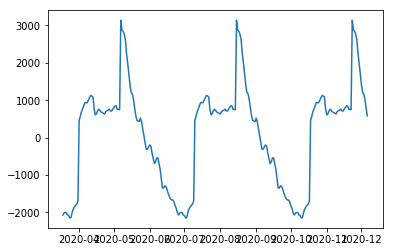

In [202]:
decomp = seasonal_decompose(df_covid_temp_france['Nombre de personnes hospitalisées'], freq = 100)
plt.plot(decomp.seasonal)

In [205]:
train = df_covid_temp_france['Nombre de personnes hospitalisées'][:198]
test = df_covid_temp_france['Nombre de personnes hospitalisées'][198:]

### Hyperparamètres

In [60]:
from math import sqrt
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

In [210]:
# one-step sarima forecast
def sarima_forecast(history, config):
    order, sorder, trend = config
    # define model
    model = SARIMAX(history, order=order, seasonal_order=sorder, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
    # fit model
    model_fit = model.fit(disp=False)
    # make one step forecast
    yhat = model_fit.predict(len(history), len(history))
    return yhat[0]

# root mean squared error or rmse
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
    predictions = []
    # split dataset
    train, test = train_test_split(data, n_test)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # fit model and make forecast for history
        yhat = sarima_forecast(history, cfg)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
    # estimate prediction error
    error = measure_rmse(test, predictions)
    return error

# score a model, return None on failure
def score_model(data, n_test, cfg, debug=False):
	result = None
	# convert config to a key
	key = str(cfg)
	# show all warnings and fail on exception if debugging
	if debug:
		result = walk_forward_validation(data, n_test, cfg)
	else:
		# one failure during model validation suggests an unstable config
		try:
			# never show warnings when grid searching, too noisy
			with catch_warnings():
				filterwarnings("ignore")
				result = walk_forward_validation(data, n_test, cfg)
		except:
			error = None
	# check for an interesting result
	if result is not None:
		print(' > Model[%s] %.3f' % (key, result))
	return (key, result)

# grid search configs
def grid_search(data, cfg_list, n_test, parallel=True):
	scores = None
	if parallel:
		# execute configs in parallel
		executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
		tasks = (delayed(score_model)(data, n_test, cfg) for cfg in cfg_list)
		scores = executor(tasks)
	else:
		scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
	# remove empty results
	scores = [r for r in scores if r[1] != None]
	# sort configs by error, asc
	scores.sort(key=lambda tup: tup[1])
	return scores

# create a set of sarima configs to try
def sarima_configs(seasonal):
    models = []
    # define config lists
    p_params = [0, 1, 2]
    d_params = [0, 1]
    q_params = [0, 1, 2]
    t_params = ['n','c','t','ct']
    P_params = [0, 1, 2]
    D_params = [0, 1]
    Q_params = [0, 1, 2]
    m_params = seasonal
    # create config instances
    for p in p_params:
        for d in d_params:
            for q in q_params:
                for t in t_params:
                    for P in P_params:
                        for D in D_params:
                            for Q in Q_params:
                                for m in m_params:
                                    cfg = [(p,d,q), (P,D,Q,m), t]
                                    models.append(cfg)
    return models

if __name__ == '__main__':
	# data split
	n_test = 4
	# model configs
	cfg_list = sarima_configs([0, 4, 12])
	# grid search
	scores = grid_search(df_covid_temp_france['Nombre de personnes hospitalisées'], cfg_list, n_test)
	# list top 3 configs
	for cfg, error in scores[:3]:
		print(cfg, error)

 > Model[[(0, 0, 0), (0, 0, 0, 4), 'n']] 26315.993
 > Model[[(0, 0, 0), (0, 0, 0, 12), 'n']] 26315.993
 > Model[[(0, 0, 0), (0, 0, 0, 0), 'n']] 26315.993
 > Model[[(0, 0, 0), (0, 0, 1, 0), 'n']] 13213.320
 > Model[[(0, 0, 0), (0, 0, 1, 4), 'n']] 12099.585
 > Model[[(0, 0, 0), (0, 0, 1, 12), 'n']] 11431.669
 > Model[[(0, 0, 0), (0, 0, 2, 0), 'n']] 7053.932
 > Model[[(0, 0, 0), (0, 1, 0, 4), 'n']] 1530.361
 > Model[[(0, 0, 0), (0, 1, 0, 12), 'n']] 4936.262
 > Model[[(0, 0, 0), (0, 0, 2, 4), 'n']] 5823.647
 > Model[[(0, 0, 0), (0, 1, 1, 4), 'n']] 1697.415
 > Model[[(0, 0, 0), (0, 1, 2, 4), 'n']] 1014.179
 > Model[[(0, 0, 0), (0, 1, 1, 12), 'n']] 2675.009
 > Model[[(0, 0, 0), (1, 0, 0, 0), 'n']] 370.353
 > Model[[(0, 0, 0), (1, 0, 0, 4), 'n']] 1822.360
 > Model[[(0, 0, 0), (1, 0, 0, 12), 'n']] 4980.353
 > Model[[(0, 0, 0), (1, 0, 1, 0), 'n']] 222.374
 > Model[[(0, 0, 0), (1, 0, 1, 4), 'n']] 1810.745
 > Model[[(0, 0, 0), (1, 0, 1, 12), 'n']] 1861.650
 > Model[[(0, 0, 0), (1, 0, 2, 0), 'n']]

In [191]:
date[260]

'2020-12-03'

In [192]:
model = SARIMAX(df_covid_temp_france['Nombre de personnes hospitalisées'][:260], order=[1, 0, 2], seasonal_order=[0, 0, 2, 0], trend='ct', enforce_stationarity=False, enforce_invertibility=False)
model_fit = model.fit()
pred = model_fit.predict(start='2020-12-03', end='2021-01-20')

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


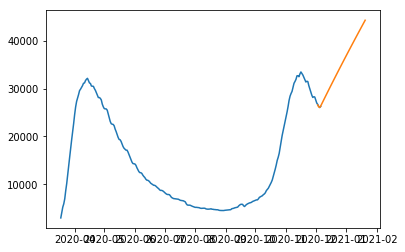

In [193]:
plt.plot(df_covid_temp_france['Nombre de personnes hospitalisées'])
plt.plot(pred)
plt.show()

In [489]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [492]:
model = ExponentialSmoothing(df_covid_temp_france['Nombre de personnes hospitalisées'][:254], trend = 'add', damped = True, seasonal = 'add', seasonal_periods = 4, freq = 'D')
model_fit = model.fit(damping_slope = 0.98)
pred = model_fit.predict(start='2020-11-28', end='2021-06-20')

In [305]:
def tracer(A_tracer, pred):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=df_covid_temp_france.index, y=df_covid_temp_france[A_tracer],
                        mode='lines',
                        name=A_tracer))

    fig.add_trace(go.Scatter(x=pred.index, y=pred,
                        mode='lines',
                        name='Prédiction'))

    fig.update_layout(title = 'Prédiction: ' + A_tracer,
                       xaxis_title = 'Jour',
                       yaxis_title = A_tracer)
    fig.show()

In [306]:
tracer('Nombre de personnes hospitalisées', pred)

In [510]:
model = ExponentialSmoothing(df_covid_temp_france['Nombre de personnes en réanimation'][:254], trend = 'add', damped = True, seasonal = 'add', seasonal_periods = 4, freq = 'D')
model_fit = model.fit(damping_slope = 0.968)
pred = model_fit.predict(start='2020-11-28', end='2021-06-20')

In [511]:
tracer('Nombre de personnes en réanimation', pred)

In [512]:
model = ExponentialSmoothing(df_covid_temp_france['Nombre cumulé de décès'][:254], trend = 'add', damped = True, seasonal = 'add', seasonal_periods = 4, freq = 'D')
model_fit = model.fit(damping_slope = 0.968)
pred = model_fit.predict(start='2020-11-28', end='2021-06-20')

In [513]:
tracer('Nombre cumulé de décès', pred)

In [441]:
from statsmodels.regression.linear_model import OLS, add_constant

In [541]:
df1 = pd.DataFrame(df_covid_temp.iloc[df_covid_temp.shape[0]-14, 0])
df2 = pd.DataFrame(df_maladies_temp.iloc[df_maladies_temp.shape[0]-14, 0])

X = np.array([df2['Taux hospitalisation asthme'].iloc[i] for i in range(len(df2.index))])
X_ = add_constant(X)
Y = np.array([df1['Nombre cumulé de décès'].iloc[i] for i in range(len(df1.index))])

df = pd.DataFrame(X_, columns = ['Taux hospitalisation asthme', 'cst'])
df['Nombre cumulé de décès'] = Y

model = OLS(Y, X_)
model_fit = model.fit()

#x_range = np.linspace(np.min(X), np.max(X), 96)

y_range = model_fit.predict(X_)

fig = px.scatter(df, x='Taux hospitalisation asthme', y='Nombre cumulé de décès', opacity = 0.65)
fig.add_traces(go.Scatter(x=X_, y=y_range, name='Regression Fit'))
fig.show()

In [538]:
df1 = pd.DataFrame(df_covid_temp.iloc[df_covid_temp.shape[0]-14, 0])
df2 = pd.DataFrame(df_maladies_temp.iloc[df_maladies_temp.shape[0]-14, 0])

X = np.array([df2['Taux hospitalisation asthme'].iloc[i] for i in range(len(df2.index))])
X_ = add_constant(X)
Y = np.array([df1['Nombre cumulé de décès'].iloc[i] for i in range(len(df1.index))])

df = pd.DataFrame(X_, columns = ['Taux hospitalisation asthme', 'cst'])
df['Nombre cumulé de décès'] = Y

model = OLS(Y, X_)
model_fit = model.fit()

x_range = np.linspace(np.min(X), np.max(X), 96)
x_range_ = add_constant(x_range)
y_range = model_fit.predict(x_range_)

figure = go.Figure()
figure.add_traces(go.Scatter(x=X, y=Y, name="Cloud", mode = "markers"))
figure.add_traces(go.Scatter(x=x_range, y=y_range, name="Regression Fit", mode = "lines"))
figure.show()

In [423]:
model.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.245
Model:                            OLS   Adj. R-squared:                  0.237
Method:                 Least Squares   F-statistic:                     30.79
Date:                Mon, 14 Dec 2020   Prob (F-statistic):           2.59e-07
Time:                        19:29:01   Log-Likelihood:                -729.06
No. Observations:                  96   AIC:                             1460.
Df Residuals:                      95   BIC:                             1463.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0834      0.015      5.549      0.000       0.054       0.113
==============================================================================
Omnibus:                       40.054   Durbin-Watson:                   1.501
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               88.639
Skew:                           1.595   Prob(JB):                     5.65e-20
Kurtosis:                       6.462   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Autre modélisation 

In [147]:
df_maladies_temp_france2 = df_maladies_temp_france.copy()

In [148]:
df_maladies_temp_france.shape

(38, 6)

### Intepolation de la tablea maladies France

In [149]:
#df_maladies_temp_france2.drop(df_maladies_temp_france2.index[0], inplace=True)
df_maladies_temp_france2['Taux hospitalisation asthme'] = np.nan
df_maladies_temp_france2['Taux hospitalisation allergie'] = np.nan
df_maladies_temp_france2['Taux hospitalisation bronchite'] = np.nan
df_maladies_temp_france2['Taux hospitalisation grippe'] = np.nan
df_maladies_temp_france2['Taux hospitalisation ORL'] = np.nan
df_maladies_temp_france2['Taux hospitalisation pneumopathie'] = np.nan
df_maladies_temp_france2.head()

,Taux hospitalisation asthme,Taux hospitalisation allergie,Taux hospitalisation bronchite,Taux hospitalisation grippe,Taux hospitalisation ORL,Taux hospitalisation pneumopathie
2020-S12,NaN,NaN,NaN,NaN,NaN,NaN
2020-S13,NaN,NaN,NaN,NaN,NaN,NaN
2020-S14,NaN,NaN,NaN,NaN,NaN,NaN
2020-S15,NaN,NaN,NaN,NaN,NaN,NaN
2020-S16,NaN,NaN,NaN,NaN,NaN,NaN


In [150]:
df_maladie_all=pd.concat([df_maladies_temp_france,df_maladies_temp_france2,df_maladies_temp_france2,df_maladies_temp_france2,df_maladies_temp_france2,df_maladies_temp_france2,df_maladies_temp_france2], ignore_index=False)

In [151]:
df_maladie_all.shape

(266, 6)

In [241]:
df_maladie_all.head(40)

,Taux hospitalisation asthme,Taux hospitalisation allergie,Taux hospitalisation bronchite,Taux hospitalisation grippe,Taux hospitalisation ORL,Taux hospitalisation pneumopathie,Date
2020-S12,2615.0,816.0,2105.0,1664.0,608.0,6966.0,2020-03-16
2020-S12,NaN,NaN,NaN,NaN,NaN,NaN,2020-03-17
2020-S12,NaN,NaN,NaN,NaN,NaN,NaN,2020-03-18
2020-S12,NaN,NaN,NaN,NaN,NaN,NaN,2020-03-19
2020-S12,NaN,NaN,NaN,NaN,NaN,NaN,2020-03-20
2020-S12,NaN,NaN,NaN,NaN,NaN,NaN,2020-03-21
2020-S12,NaN,NaN,NaN,NaN,NaN,NaN,2020-03-22
2020-S13,NaN,NaN,NaN,NaN,NaN,NaN,2020-03-23
2020-S13,NaN,NaN,NaN,NaN,NaN,NaN,2020-03-24
2020-S13,NaN,NaN,NaN,NaN,NaN,NaN,2020-03-25


In [153]:
df_maladie_all["Date"]=df_maladie_all.index

In [154]:
df_maladie_all.head()

,Taux hospitalisation asthme,Taux hospitalisation allergie,Taux hospitalisation bronchite,Taux hospitalisation grippe,Taux hospitalisation ORL,Taux hospitalisation pneumopathie,Date
2020-S12,2615.0,816.0,2105.0,1664.0,608.0,6966.0,2020-S12
2020-S13,2490.0,1213.0,2140.0,1710.0,966.0,6784.0,2020-S13
2020-S14,2713.0,1263.0,2380.0,1795.6,943.0,6968.0,2020-S14
2020-S15,2709.0,1070.0,2658.0,1965.6,841.0,6866.0,2020-S15
2020-S16,2567.0,982.0,2972.0,2023.8,736.0,7158.0,2020-S16


In [155]:
df_maladie_all.sort_values("Date", ascending=True, inplace=True)
df_maladie_all.head(10)

,Taux hospitalisation asthme,Taux hospitalisation allergie,Taux hospitalisation bronchite,Taux hospitalisation grippe,Taux hospitalisation ORL,Taux hospitalisation pneumopathie,Date
2020-S12,2615.0,816.0,2105.0,1664.0,608.0,6966.0,2020-S12
2020-S12,NaN,NaN,NaN,NaN,NaN,NaN,2020-S12
2020-S12,NaN,NaN,NaN,NaN,NaN,NaN,2020-S12
2020-S12,NaN,NaN,NaN,NaN,NaN,NaN,2020-S12
2020-S12,NaN,NaN,NaN,NaN,NaN,NaN,2020-S12
2020-S12,NaN,NaN,NaN,NaN,NaN,NaN,2020-S12
2020-S12,NaN,NaN,NaN,NaN,NaN,NaN,2020-S12
2020-S13,NaN,NaN,NaN,NaN,NaN,NaN,2020-S13
2020-S13,NaN,NaN,NaN,NaN,NaN,NaN,2020-S13
2020-S13,NaN,NaN,NaN,NaN,NaN,NaN,2020-S13


In [156]:
df_maladie_all['Date'] = pd.date_range(start='03/16/2020', periods=len(df_maladie_all), freq='D')

In [157]:
df_maladie_all2 = df_maladie_all.interpolate()
df_maladie_all2.head(10)

,Taux hospitalisation asthme,Taux hospitalisation allergie,Taux hospitalisation bronchite,Taux hospitalisation grippe,Taux hospitalisation ORL,Taux hospitalisation pneumopathie,Date
2020-S12,2615.000000,816.000000,2105.000000,1664.000000,608.000000,6966.000000,2020-03-16
2020-S12,2604.583333,849.083333,2107.916667,1667.833333,637.833333,6950.833333,2020-03-17
2020-S12,2594.166667,882.166667,2110.833333,1671.666667,667.666667,6935.666667,2020-03-18
2020-S12,2583.750000,915.250000,2113.750000,1675.500000,697.500000,6920.500000,2020-03-19
2020-S12,2573.333333,948.333333,2116.666667,1679.333333,727.333333,6905.333333,2020-03-20
2020-S12,2562.916667,981.416667,2119.583333,1683.166667,757.166667,6890.166667,2020-03-21
2020-S12,2552.500000,1014.500000,2122.500000,1687.000000,787.000000,6875.000000,2020-03-22
2020-S13,2542.083333,1047.583333,2125.416667,1690.833333,816.833333,6859.833333,2020-03-23
2020-S13,2531.666667,1080.666667,2128.333333,1694.666667,846.666667,6844.666667,2020-03-24
2020-S13,2521.250000,1113.750000,2131.250000,1698.500000,876.500000,6829.500000,2020-03-25


In [160]:
df_maladie_all3=df_maladie_all2.loc[(df_maladie_all2['Date'] >= "2020-03-18")]

In [165]:
df_covid_temp_france.head()

,Nombre de personnes hospitalisées,Nombre de personnes hospitalisées - Hommes,Nombre de personnes hospitalisées - Femmes,Nombre de personnes en réanimation,Nombre de personnes en réanimation - Hommes,Nombre de personnes en réanimation - Femmes,Nombre cumulé de décès,Nombre cumulé de décès - Hommes,Nombre cumulé de décès - Femmes,Taux de positivité,Nombre de passages COVID-19 quotidien aux urgences,Nombre de passages COVID-19 quotidien aux urgences - moins de 15 ans,Nombre de passages COVID-19 quotidien aux urgences - 15-44 ans,Nombre de passages COVID-19 quotidien aux urgences - 45-64 ans,Nombre de passages COVID-19 quotidien aux urgences - 65-74 ans,Nombre de passages COVID-19 quotidien aux urgences - 75 ans ou plus
2020-03-18,2972,1685,1248,771,525,239,218,121,96,NaN,2355,96,1019,699,233,308
2020-03-19,4073,2256,1632,1002,689,284,327,179,136,NaN,2367,94,939,736,257,341
2020-03-20,5226,2912,2134,1297,905,362,450,250,190,NaN,2882,82,1113,894,340,453
2020-03-21,5900,3298,2401,1453,1018,401,525,297,219,NaN,2696,83,1095,824,270,424
2020-03-22,6954,3906,2815,1674,1176,461,632,356,263,NaN,2818,75,1101,906,290,446


In [166]:
df_covid_temp_france["Date"]=df_covid_temp_france.index

In [167]:
data_frames = [df_covid_temp_france, df_maladie_all3]
df_final_2 = reduce(lambda left,right: pd.merge(left,right,on='Date'), data_frames)

In [168]:
df_final_2.head()

,Nombre de personnes hospitalisées,Nombre de personnes hospitalisées - Hommes,Nombre de personnes hospitalisées - Femmes,Nombre de personnes en réanimation,Nombre de personnes en réanimation - Hommes,Nombre de personnes en réanimation - Femmes,Nombre cumulé de décès,Nombre cumulé de décès - Hommes,Nombre cumulé de décès - Femmes,Taux de positivité,...,Nombre de passages COVID-19 quotidien aux urgences - 45-64 ans,Nombre de passages COVID-19 quotidien aux urgences - 65-74 ans,Nombre de passages COVID-19 quotidien aux urgences - 75 ans ou plus,Date,Taux hospitalisation asthme,Taux hospitalisation allergie,Taux hospitalisation bronchite,Taux hospitalisation grippe,Taux hospitalisation ORL,Taux hospitalisation pneumopathie
0,2972,1685,1248,771,525,239,218,121,96,NaN,...,699,233,308,2020-03-18,2594.166667,882.166667,2110.833333,1671.666667,667.666667,6935.666667
1,4073,2256,1632,1002,689,284,327,179,136,NaN,...,736,257,341,2020-03-19,2583.750000,915.250000,2113.750000,1675.500000,697.500000,6920.500000
2,5226,2912,2134,1297,905,362,450,250,190,NaN,...,894,340,453,2020-03-20,2573.333333,948.333333,2116.666667,1679.333333,727.333333,6905.333333
3,5900,3298,2401,1453,1018,401,525,297,219,NaN,...,824,270,424,2020-03-21,2562.916667,981.416667,2119.583333,1683.166667,757.166667,6890.166667
4,6954,3906,2815,1674,1176,461,632,356,263,NaN,...,906,290,446,2020-03-22,2552.500000,1014.500000,2122.500000,1687.000000,787.000000,6875.000000


# Machine learning sur séries temporelles

In [169]:
df_final3= df_final_2.set_index("Date")

### Stationnarité d'une série temporelle  

Une série chronologie peut être interprété à condition qu'elle soit stationnaire.  
Cela signifie que la distribution des données ne change pas au cours du temps.  

Pour qu'une série soit stationnaire, elle doit remplir 3 critères (pour chaque date t) :  

$\mathbb{E}$$(y_t)$ = m  : Aucune tendance <br>
$\mathrm{Var}$$(y_t)$ = $\sigma^2$  : Variance constante <br>
$\mathrm{Cov}$$(y_t, y_{t-k})$ = $\rho_k$    Autocorrelation est constante <br>


Comme pour la modélisation en Machine Learning "classique", nous diviserons les données mais en fonction du temps.
Les données du passées serviront à prédire les données futures


Dans un premier temps, nous modéliserons la série temporelle **"Nombre de personnes mort du Covid 19"**

**Remarque** : 
A première vue, la série n'est pas stationnaire.
Pour en être sûr, nous allons appliquer des méthodes plus formelle comme des tests statistiques.  

Le test le plus utilisé est le test de **Dicky-Fuller augmenté** : 

 <ins>Soit le modèle</ins> :  $y_t$ = $\rho$$y_{t-1}$ + $u_t$

$H_0$ : $\rho$= 1 (la série n'est pas stationnaire) vs $H_1$ : $\lvert$ $\rho$ $\rvert$ $\lt$ 1 (la série est stationnaire)





In [178]:
from statsmodels.tsa.stattools import adfuller

results=adfuller(df_final3["Nombre cumulé de décès"])
print(results)

(2.905188290858863, 1.0, 16, 247, {'1%': -3.457105309726321, '5%': -2.873313676101283, '10%': -2.5730443824681606}, 2495.384123395775)


 <ins>Analyse résultat test</ins> : La deuxième élément représente la p-value, donc **1 > 0.05**  donc on ne rejette pas l'hypothèse $H_0$,  
la série n'est pas stationnaire.

<ins>Solution</ins> : Pour que notre série devienne stationnaire, nous allons devoir la transformer. (C'est l'équivalent de la partie "features engineering" dans le Machine Learning classique)

Pour cela, nous allons appliquer la différence :  $\Delta$ = $y_t$ - $y_{t-1}$





In [184]:
df_stationary= df_final3["Nombre cumulé de décès"].diff().dropna()

In [185]:
from statsmodels.tsa.stattools import adfuller

results2=adfuller(df_stationary)
print(results2)

(-3.7709306539737746, 0.00321913516695066, 15, 247, {'1%': -3.457105309726321, '5%': -2.873313676101283, '10%': -2.5730443824681606}, 2492.4841861493733)


 <ins>Analyse résultat test 2 </ins> : **0.0032 < 0.05**  donc on rejette l'hypothèse $H_0$,  
la série est stationnaire.

<ins>Solution</ins> : A priori notre série est stationnaire mais lorsqu'on observe l'ACF et PACF ce n'est toujours pas le cas.  
Nous allons appliquer le log du ratio de différence :  $y_t$ = $\log$ $ \left( \frac{y_t}{Y_{t-1}} \right)$

In [186]:
df_stationary_mort = np.log(df_final3["Nombre cumulé de décès"]/df_final3["Nombre cumulé de décès"].shift(1))
df_stationary_mort = df_stationary_mort.dropna()

print(df_stationary_mort)
test=pd.DataFrame(df_stationary_mort)
test.isnull().sum()

df_stationary_mort.index = pd.DatetimeIndex(df_stationary_mort.index.values,
                               freq=df_stationary_mort.index.inferred_freq)




Date
2020-03-19    0.405465
2020-03-20    0.319287
2020-03-21    0.154151
2020-03-22    0.185491
2020-03-23    0.308043
                ...   
2020-12-02    0.008392
2020-12-03    0.008724
2020-12-04    0.007532
2020-12-05    0.005678
2020-12-06    0.004593
Name: Nombre cumulé de décès, Length: 263, dtype: float64


In [187]:
results3=adfuller(df_stationary_mort)
print(results3)

(-3.890146709704594, 0.002108570530033518, 15, 247, {'1%': -3.457105309726321, '5%': -2.873313676101283, '10%': -2.5730443824681606}, -2266.0153312022326)


 <ins>Analyse résultat test 2 </ins> : La deuxième élément représente la p-value, donc **$2.01$ x $10^{-30}$ < $0.05$**  donc on  rejette l'hypothèse $H_0$,  
la série est stationnaire.

### Sléection des meilleurs paramètres P et q  

L'un des principaux moyens d'identifier les bons paramètres consiste à utiliser la fonction d'autocorrélation ACF et/ou la fonction d'autocorrélation partielle PACF.  

ACF(p) : corr($y_t$, $y_{t-p}$)  

PACF(p) : représente la corrélation entre la série et la version décalée d'elle-même après avoir soustrait l'effet de la corrélation à des décalages plus petits

En comparant l'ACF et le PACF, nous pouvons déduire l'ordre du modèle.





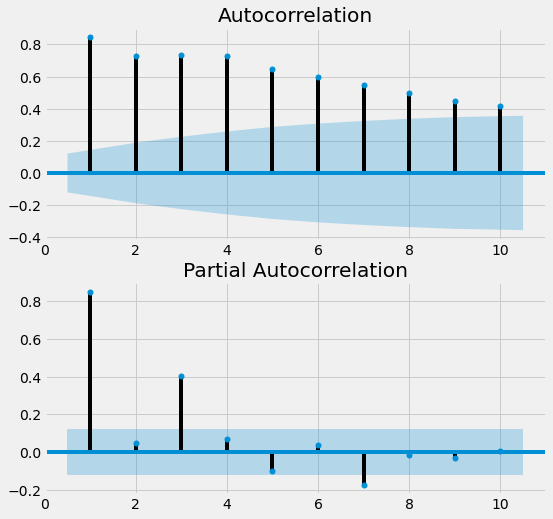

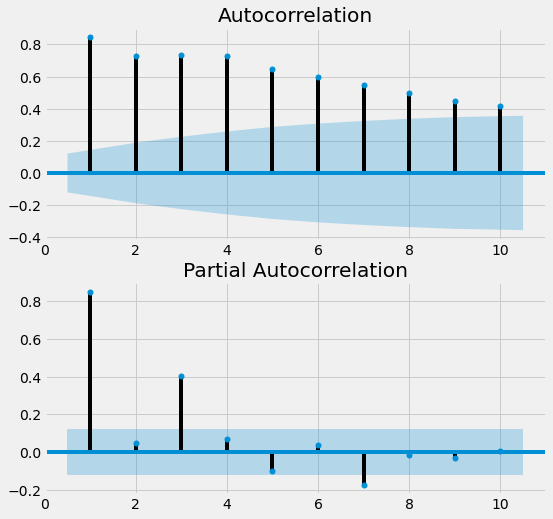

In [188]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,8))

plot_acf(df_stationary_mort, lags=10, zero=False, ax=ax1)

plot_pacf(df_stationary_mort, lags=10, zero=False, ax=ax2)

Si les valeurs sont petites et se trouvent à l'intérieur de la zone ombrée en bleu, alors cela signifie qu'elles ne sont pas statistiquement significatives

<ins>Analyse résultat test 3 </ins> : L'ACF nous indique un modèle AR(4), or la PACF s'arrête au retard 1 donc nous avons un modèle AR(1)



 <ins>Modèle AR(p)</ins> :  $y_t$ = $\alpha_1$$y_{t-1}$ + $\alpha_2$$y_{t-2}$ + ... + $\alpha_p$$y_{t-p}$+  $u_t$  

 <ins>Modèle MA(q)</ins> :  $y_t$ = $\beta_1$$u_{t-1}$ + $\beta_2$$u_{t-2}$ + ... + $\beta_q$$u_{t-q}$+  $u_t$  
 
  <ins>Modèle ARMA(p,q)</ins> :  $y_t$ = $\alpha_1$$y_{t-1}$ + $\alpha_2$$y_{t-2}$ + ... + $\alpha_p$$y_{t-p}$ + $\beta_1$$u_{t-1}$ + $\beta_2$$u_{t-2}$ + ... + $\beta_q$$u_{t-q}$+  $u_t$ 
 
 
 ( $u_t$ représente le bruit blanc, cela signifie que chaque choc de la série à la date est aléatoire et n'est donc pas lié aux autres chocs de la série)

### Modèle 1 :

$ \left( \frac{mortCovid_t}{mortCovid_{t-1}} \right)$ =  $\alpha_0$ +$\alpha_1$ $\log$ $ \left( \frac{mortCovid_{t-1}}{mortCovid_{t-2}} \right)$ + $u_t$ 

In [190]:
from statsmodels.tsa.arima_model import ARMA

model= ARMA(df_stationary_mort, order=(1,0))

results= model.fit()

In [191]:
print(results.summary())

                                ARMA Model Results                                
Dep. Variable:     Nombre cumulé de décès   No. Observations:                  263
Model:                         ARMA(1, 0)   Log Likelihood                 711.015
Method:                           css-mle   S.D. of innovations              0.016
Date:                    Tue, 15 Dec 2020   AIC                          -1416.030
Time:                            00:04:07   BIC                          -1405.313
Sample:                        03-19-2020   HQIC                         -1411.723
                             - 12-06-2020                                         
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                            0.1372      0.146      0.937      0.349      -0.150       0.424
ar.L1.Nombre cumulé de décès     0.9956      

<ins>Interprétation modèle 1 : ARMA(1,0)</ins> : 

$\alpha_1$ = 0.99 : représente le coefficient de la variable transformée. Le coefficient est significatif au seuil de 1%




### Prévision du modèle 1 :

Méthode One-step-ahead : prédiction d'une seule valeur à l'avance

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


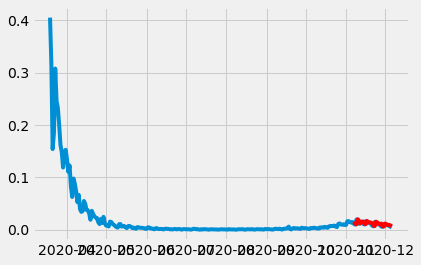

In [192]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model=SARIMAX(df_stationary_mort, order=(1,0,0), trend='c')

results=model.fit()
forecast= results.get_prediction(start=-30)

mean_forecast = forecast.predicted_mean

confidence_intervals= forecast.conf_int()

plt.plot(df_stationary_mort.index, df_stationary_mort, label='observed')
plt.plot(mean_forecast.index, mean_forecast.values, color='red', label='forecast')

### Prédiction dynamique

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


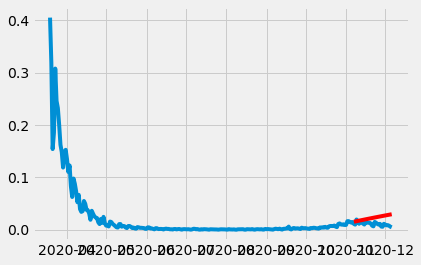

In [193]:
results=model.fit()
forecast= results.get_prediction(start=-30, dynamic=True)

mean_forecast = forecast.predicted_mean

confidence_intervals= forecast.conf_int()

plt.plot(df_stationary_mort.index, df_stationary_mort, label='observed')
plt.plot(mean_forecast.index, mean_forecast.values, color='red', label='forecast')

### Prédiction out-Sample

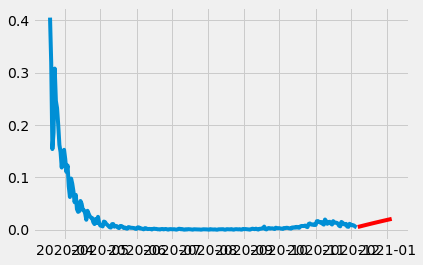

In [194]:
forecast= results.get_forecast(steps=30, dynamic=True) #Prédiction de 30 jours

mean_forecast = forecast.predicted_mean

confidence_intervals= forecast.conf_int()

plt.plot(df_stationary_mort.index, df_stationary_mort, label='observed')
plt.plot(mean_forecast.index, mean_forecast.values, color='red', label='forecast')

<ins>Interprétation de la prédiction out-sample : </ins> : 

Nous pouvons constater une augmentation du nombre de décès liés au Covid après le 29 novembre 2020

### Modélisation 2 : Modèle ARMAX

Il existe une extension des modèles ARMA qui consiste à ajouter une variable exogène au modèle.
C'est une combinaison entre un modèle ARMA et une régréssion linéaire.
Ici nous allons essayé de voir si les maladies scrappées auparavant, à savoir :  

Grippe <br>
Asthme <br>
Allergie <br>
Orl <br>
Pneumopathie<br>
Bronchite <br>



<ins>Modèle ARMAX(1,1)</ins> :  $y_t$ = $\zeta_1$$x_t$ + $\alpha_1$$y_{t-1}$ + $\beta_1$$u_{t-1}$ + $u_t$ 

#### Staionnarisation de la variable grippe

In [195]:
#df_final2.drop(df_maladie_all.index[0], inplace=True)

results_g=adfuller(df_final3["Taux hospitalisation grippe"])
print(results_g)

(-2.271632500258673, 0.18128031205697798, 4, 259, {'1%': -3.4558530692911504, '5%': -2.872764881778665, '10%': -2.572751643088207}, 2513.9980785020084)


In [197]:
df_stationary_g= df_final3["Taux hospitalisation grippe"].diff().dropna()

In [198]:
results_g2=adfuller(df_stationary_g)
print(results_g2)

(-6.838752522731391, 1.8139308513219172e-09, 3, 259, {'1%': -3.4558530692911504, '5%': -2.872764881778665, '10%': -2.572751643088207}, 2508.9444316766185)


In [199]:
df_stationary_g.index = pd.DatetimeIndex(df_stationary_g.index.values,
                               freq=df_stationary_mort.index.inferred_freq)



#### Staionnarisation de la variable asthme

In [200]:
results_a = adfuller(df_final3["Taux hospitalisation asthme"])
print(results_a)

(-2.000590747379835, 0.2863141371158634, 5, 258, {'1%': -3.455952927706342, '5%': -2.8728086526320302, '10%': -2.572774990685656}, 2288.4521947175854)


In [202]:
df_stationary_a= df_final3["Taux hospitalisation asthme"].diff().dropna()

In [203]:
results_a2=adfuller(df_stationary_a)
print(results_a2)

(-7.56613517592334, 2.9224462830706846e-11, 3, 259, {'1%': -3.4558530692911504, '5%': -2.872764881778665, '10%': -2.572751643088207}, 2281.4978041989298)


In [204]:
df_stationary_a.index = pd.DatetimeIndex(df_stationary_a.index.values,
                               freq=df_stationary_mort.index.inferred_freq)




#### Staionnarisation de la variable allergie

In [205]:
results_aa = adfuller(df_final3["Taux hospitalisation allergie"])
print(results_aa)

(-2.759676133866617, 0.06426859306818208, 12, 251, {'1%': -3.4566744514553016, '5%': -2.8731248767783426, '10%': -2.5729436702592023}, 1798.683245380157)


In [208]:
df_final3["Taux hospitalisation allergie"].index = pd.DatetimeIndex(df_final3["Taux hospitalisation allergie"].index.values,
                               freq=df_stationary_mort.index.inferred_freq)

In [209]:

df_final3["Taux hospitalisation allergie"].drop(df_final3["Taux hospitalisation allergie"].index[0], inplace=True)

#### Stationnarisation de la variable Orl

In [211]:
results_o = adfuller(df_final3["Taux hospitalisation ORL"])
print(results_o)

(-2.5900843912671876, 0.09506398864791743, 8, 255, {'1%': -3.4562572510874396, '5%': -2.8729420379793598, '10%': -2.5728461399461744}, 1655.4110914350917)


In [213]:
df_stationary_o= df_final3["Taux hospitalisation ORL"].diff().dropna()

In [214]:
results_o=adfuller(df_stationary_o)
print(results_o)

(-5.881092831339263, 3.0771460942500507e-07, 4, 258, {'1%': -3.455952927706342, '5%': -2.8728086526320302, '10%': -2.572774990685656}, 1659.4422800717593)


In [215]:
df_stationary_o.index = pd.DatetimeIndex(df_stationary_o.index.values,
                               freq=df_stationary_mort.index.inferred_freq)



#### Staionnarisation de la variable Pneumopathie

In [216]:
results_p = adfuller(df_final3["Taux hospitalisation pneumopathie"])
print(results_p)

(-2.670817392424674, 0.07922569402518453, 4, 259, {'1%': -3.4558530692911504, '5%': -2.872764881778665, '10%': -2.572751643088207}, 2002.7874921130774)


In [220]:
df_final3["Taux hospitalisation pneumopathie"].index = pd.DatetimeIndex(df_final3["Taux hospitalisation pneumopathie"].index.values,
                               freq=df_stationary_mort.index.inferred_freq)

In [221]:

df_final3["Taux hospitalisation pneumopathie"].drop(df_final3["Taux hospitalisation pneumopathie"].index[0], inplace=True)

#### Staionnarisation de la variable Bronchite

In [222]:
results_b = adfuller(df_final3["Taux hospitalisation bronchite"])
print(results_b)

(-2.631894930839751, 0.08658276171353058, 2, 261, {'1%': -3.4556556713934934, '5%': -2.872678352489859, '10%': -2.57270548832225}, 2503.7971262814144)


In [223]:
df_stationary_b= df_final3["Taux hospitalisation bronchite"].diff().dropna()

In [224]:
results_b=adfuller(df_stationary_b)
print(results_b)

(-6.632084949462905, 5.6815586390919916e-09, 2, 260, {'1%': -3.4557539868570775, '5%': -2.8727214497041422, '10%': -2.572728476331361}, 2498.530436633148)


### Création du model ARMAX avec la variable grippe

$mortCovid_t$ = $\alpha$$grippe_{t}$  + $\zeta$$mortCovid_{t-1}$ +  $u_t$ 



In [226]:
model = ARMA(df_stationary_mort, order=(1,0), exog= df_stationary_g)

results_arma1= model.fit()
print(results_arma1.summary())

                                ARMA Model Results                                
Dep. Variable:     Nombre cumulé de décès   No. Observations:                  263
Model:                         ARMA(1, 0)   Log Likelihood                 711.023
Method:                           css-mle   S.D. of innovations              0.016
Date:                    Tue, 15 Dec 2020   AIC                          -1414.045
Time:                            00:09:29   BIC                          -1399.756
Sample:                        03-19-2020   HQIC                         -1408.303
                             - 12-06-2020                                         
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                            0.1372      0.146      0.937      0.349      -0.150       0.424
Taux hospitalisation grippe  -2.989e-06   2.4

### Création du model ARMAX avec la variable asthme

$mortCovid_t$ = $\alpha$$asthme_{t}$  + $\zeta$$mortCovid_{t-1}$  +  $u_t$ 




In [227]:
model = ARMA(df_stationary_mort, order=(1,0), exog= df_stationary_a)

results_arma2= model.fit()
print(results_arma2.summary())

                                ARMA Model Results                                
Dep. Variable:     Nombre cumulé de décès   No. Observations:                  263
Model:                         ARMA(1, 0)   Log Likelihood                 711.015
Method:                           css-mle   S.D. of innovations              0.016
Date:                    Tue, 15 Dec 2020   AIC                          -1414.030
Time:                            00:09:47   BIC                          -1399.741
Sample:                        03-19-2020   HQIC                         -1408.287
                             - 12-06-2020                                         
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                            0.1372      0.146      0.937      0.349      -0.150       0.424
Taux hospitalisation asthme  -1.951e-07   3.7

### Création du model ARMAX avec la variable allergie

$mortCovid_t$ = $\alpha$$allergie_{t}$  + $\zeta$$mortCovid_{t-1}$ + $\beta$$u_{t-1}$ +  $u_t$ 




In [229]:
model = ARMA(df_stationary_mort, order=(1,0), exog= df_final3["Taux hospitalisation allergie"])

results_arma3= model.fit()
print(results_arma3.summary())

                                ARMA Model Results                                
Dep. Variable:     Nombre cumulé de décès   No. Observations:                  263
Model:                         ARMA(1, 0)   Log Likelihood                 712.808
Method:                           css-mle   S.D. of innovations              0.016
Date:                    Tue, 15 Dec 2020   AIC                          -1417.615
Time:                            00:10:22   BIC                          -1403.326
Sample:                        03-19-2020   HQIC                         -1411.873
                             - 12-06-2020                                         
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                             0.2459      0.154      1.594      0.111      -0.057       0.548
Taux hospitalisation allergie    -0.0001  

### Création du model ARMAX avec la variable ORL

$mortCovid_t$ = $\alpha$$Orl_{t}$  + $\zeta$$mortCovid_{t-1}$ + $\beta$$u_{t-1}$ +  $u_t$ 





In [230]:
model = ARMA(df_stationary_mort, order=(1,0), exog= df_stationary_o)

results_arma4= model.fit()
print(results_arma4.summary())

                                ARMA Model Results                                
Dep. Variable:     Nombre cumulé de décès   No. Observations:                  263
Model:                         ARMA(1, 0)   Log Likelihood                 711.177
Method:                           css-mle   S.D. of innovations              0.016
Date:                    Tue, 15 Dec 2020   AIC                          -1414.355
Time:                            00:10:35   BIC                          -1400.066
Sample:                        03-19-2020   HQIC                         -1408.612
                             - 12-06-2020                                         
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                            0.1359      0.145      0.937      0.349      -0.148       0.420
Taux hospitalisation ORL      7.375e-05      

### Création du model ARMAX avec la variable Pneumopathie

$mortCovid_t$ = $\alpha$$Pneumopathie_{t}$  + $\zeta$$mortCovid_{t-1}$ +  $u_t$ 

In [232]:
model = ARMA(df_stationary_mort, order=(1,0), exog= df_final3["Taux hospitalisation pneumopathie"])

results_arma5= model.fit()
print(results_arma5.summary())

                                ARMA Model Results                                
Dep. Variable:     Nombre cumulé de décès   No. Observations:                  263
Model:                         ARMA(1, 0)   Log Likelihood                 711.016
Method:                           css-mle   S.D. of innovations              0.016
Date:                    Tue, 15 Dec 2020   AIC                          -1414.031
Time:                            00:11:08   BIC                          -1399.743
Sample:                        03-19-2020   HQIC                         -1408.289
                             - 12-06-2020                                         
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const                                 0.1241      0.349      0.356      0.722      -0.559       0.808
Taux hospitalisation pneumopat

### Création du model ARMAX avec la variable Bronchite

$mortCovid_t$ = $\alpha$$Bronchite_{t}$  + $\zeta$$mortCovid_{t-1}$ +  $u_t$ 

In [233]:
model = ARMA(df_stationary_mort, order=(1,0), exog= df_stationary_b)

results_arma6= model.fit()
print(results_arma6.summary())

                                ARMA Model Results                                
Dep. Variable:     Nombre cumulé de décès   No. Observations:                  263
Model:                         ARMA(1, 0)   Log Likelihood                 711.016
Method:                           css-mle   S.D. of innovations              0.016
Date:                    Tue, 15 Dec 2020   AIC                          -1414.032
Time:                            00:11:21   BIC                          -1399.743
Sample:                        03-19-2020   HQIC                         -1408.290
                             - 12-06-2020                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                              0.1372      0.146      0.937      0.349      -0.150       0.424
Taux hospitalisation bronchite  1.228e-

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


### Analyse temporelle de la variable nombre de personnes hostpitalisés (sans transformation de la série)

Au lieu de prendre la différence ou tout autre transformation de la série temporelle, nous allons prendre la somme cumulée (ou intégrale).
Cette transformation nous permettra de réaliser des prédictions des valeurs "brute" de la série. Les modèles ARIMA représentes une extensions des modèles ARMA avec en plus un paramètre de différentiation auto-intégré.  

ARIMA : Autoregressive integrated Moving Average

Cette méthode ne peut pas s'appliquer à la variable "mort covid 19" car nous avons appliquer une transformation logarithmique et non une transformation différentielle



### Aperçu du nombre de lag nécessaire à la staionnarisation de la variable hostpitalisation C19

In [234]:
results=adfuller(df_final3["Nombre de personnes hospitalisées"])
print(results)

(-1.6757485575228597, 0.4436488621451638, 16, 247, {'1%': -3.457105309726321, '5%': -2.873313676101283, '10%': -2.5730443824681606}, 3206.946889674941)


In [235]:
df_stationary_h= df_final3["Nombre de personnes hospitalisées"].diff().dropna()

In [236]:
results2=adfuller(df_stationary_h)
print(results2)

(-3.9452413639652817, 0.0017260063542060967, 15, 247, {'1%': -3.457105309726321, '5%': -2.873313676101283, '10%': -2.5730443824681606}, 3188.8969560656933)


La variable "hospit C19" (nombre de personnes hostpitalisés du Covid 19) nécessite de différencié 1 seule fois 

### Recherche du meilleur paramètre

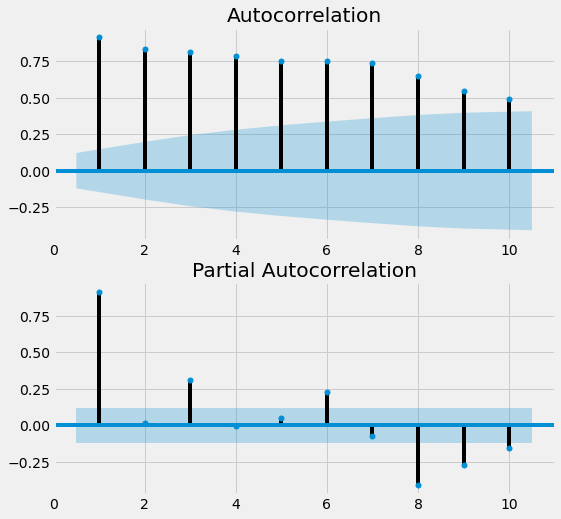

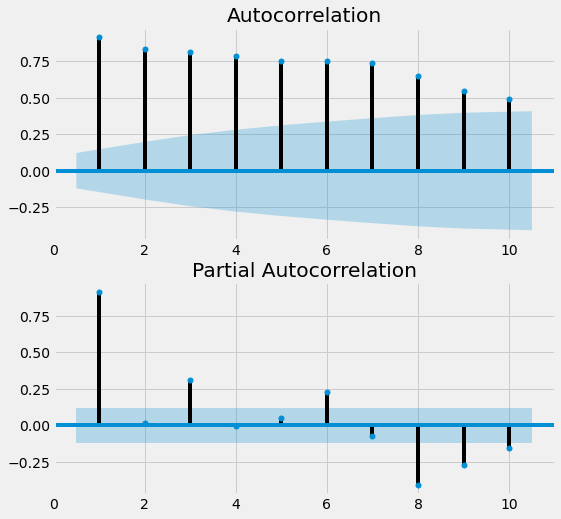

In [237]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,8))

plot_acf(df_stationary_h, lags=10, zero=False, ax=ax1)

plot_pacf(df_stationary_h, lags=10, zero=False, ax=ax2)

In [239]:
df_final3["Nombre de personnes hospitalisées"].index = pd.DatetimeIndex(df_final3["Nombre de personnes hospitalisées"].index.values,
                               freq=df_stationary_mort.index.inferred_freq)

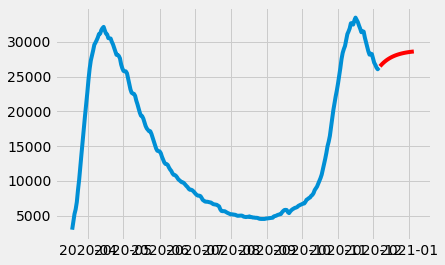

In [240]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(df_final3["Nombre de personnes hospitalisées"], order=(1,1,0))

model_results=model.fit()

mean_forecast= model_results.get_forecast(steps=30).predicted_mean


plt.plot(df_final3["Nombre de personnes hospitalisées"].index, df_final3["Nombre de personnes hospitalisées"], label='observed')
plt.plot(mean_forecast.index, mean_forecast.values, color='red', label='forecast')

